# Classification des types de consommation des ménages Haitien
  **Préparé et présenté par :** Saint Germain Emode / Darlens Damisca </br>
  **Email:** germodee12@gmail.com / bdamisca96@gmail.com

#### Un projet de Data Science visant à classer les ménages selon leur niveau de consommation énergétique  (faible, moyenne ou forte)* à partir des données de compteurs électriques.

## 📖 Contexte

En Haïti, l’accès à l’électricité demeure irrégulier et inégal, notamment entre zones rurales et urbaines.  
Les ménages présentent des profils de consommation très variés, rendant difficile la planification énergétique nationale.

Grâce à l’exploitation de **données issues de compteurs intelligents (smart meters)**, ce projet propose une approche basée sur **l’intelligence artificielle** pour **analyser, comprendre et classer** les comportements de consommation des foyers haïtiens.

## 🎯 Objectif du projet
Développer un **modèle d’apprentissage automatique (Machine Learning)** capable de **classifier automatiquement les ménages haïtiens** selon leur **niveau de consommation énergétique moyenne (en kW)**.

### 🧩 Objectifs spécifiques
- Analyser les profils de consommation à partir des données collectées (ampérage, transactions, zones).
- Extraire et créer des **caractéristiques (features)** pertinentes.
- Gérer le **déséquilibre des classes** dans les données.

 ## Description du jeu de données
Dans le cadre de ce projet, nous avons eu accès à un jeu de données privé fourni par la société Sigora, contenant des informations détaillées sur les compteurs des clients situés dans plusieurs communes du Nord-Ouest d’Haïti, telles que Môle Saint-Nicolas, Jean Rabel, Bombardopolis et Môle Rouge.

Ce jeu de données couvre la période de janvier 2023 à septembre 2025 et comprend notamment :
- La consommation quotidienne de chaque client,
- Les transactions financières effectuées sur leurs compteurs.

# importer les bibliothèques

In [2]:
# Import des bibliothèques courantes
import sys
import math
from pathlib import Path
import json
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Pour modélisation / prétraitement
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
import joblib

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

print('XGBoost available:', XGBOOST_AVAILABLE)

# Options d'affichage
pd.set_option('display.max_columns', 200)
sns.set_theme()


XGBoost available: True


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Charger le fichier JSON et vérifier sa présence
S’assurer que le fichier existe et afficher un exemple d’enregistrement.

In [4]:
DATA_PATH = Path('/content/drive/MyDrive/sigorahaitimetedatas.json')

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Fichier introuvable : {DATA_PATH}")

with open(DATA_PATH, 'r') as f:
    raw = json.load(f)

print("Nombre d'enregistrements (foyers) dans le JSON :", len(raw))

# Affiche un exemple formaté du premier enregistrement
import json as _json
print(_json.dumps(raw[0], indent=2, ensure_ascii=False))


Nombre d'enregistrements (foyers) dans le JSON : 2716
{
  "numero_compteur": "#0054",
  "nom_complet": "Jean-Baptiste jeandeline",
  "consommations": [
    {
      "date": 1748868362453,
      "amperage": 0.04,
      "capacite": "120",
      "argent_depense": 0.00039999999999999996,
      "version": "9.6",
      "prix": 300,
      "wifi_strength": "31"
    },
    {
      "date": 1748868366260,
      "amperage": 0.03,
      "capacite": "120",
      "argent_depense": 0.0003,
      "version": "9.6",
      "prix": 300,
      "wifi_strength": "31"
    },
    {
      "date": 1748868368544,
      "amperage": 0.04,
      "capacite": "120",
      "argent_depense": 0.00039999999999999996,
      "version": "9.6",
      "prix": 300,
      "wifi_strength": "31"
    },
    {
      "date": 1748868372370,
      "amperage": 0.03,
      "capacite": "120",
      "argent_depense": 0.0003,
      "version": "9.6",
      "prix": 300,
      "wifi_strength": "31"
    },
    {
      "date": 1748868374565,
     

# Aplatir la structure JSON en DataFrame (une ligne = une mesure)
convertir la structure imbriquée (consommations pour chaque foyer) en un tableau plat exploitable.

In [5]:
# Construire manuellement les lignes (fonctionne même si structure varie légèrement)

from collections import Counter
import re
records = []

for foyer in raw:
    numero_compteur = foyer.get("numero_compteur")
    nom = foyer.get("nom_complet")
    metadata = foyer.get("metadata", {}) or {}
    zone = metadata.get("zone")
    type_maison = metadata.get("type_maison")
    nb_personnes = metadata.get("Pp_fanmi", np.nan)

    for conso in foyer.get("consommations", []):
        capacite_val = conso.get("capacite")
        try:
            capacite_val = float(capacite_val) if capacite_val not in (None, "") else np.nan
        except:
            capacite_val = np.nan

        wifi_val = conso.get("wifi_strength")
        try:
            wifi_val = float(wifi_val) if wifi_val not in (None, "") else np.nan
        except:
            wifi_val = np.nan

        records.append({
            "numero_compteur": numero_compteur,
            "nom_complet": nom,
            "zone": zone,
            "type_maison": type_maison,
            "nombre_personnes": nb_personnes,
            "date_ts": conso.get("date"),          # timestamp en ms
            "amperage": conso.get("amperage"),
            "capacite": capacite_val,
            "argent_depense": conso.get("argent_depense"),
            "prix": conso.get("prix"),
            "wifi_strength": wifi_val,
            "version": conso.get("version", None)
        })

df = pd.DataFrame(records)
print("Lignes dans le DataFrame aplati :", len(df))
df.head(6)

Lignes dans le DataFrame aplati : 6644210


,numero_compteur,nom_complet,zone,type_maison,nombre_personnes,date_ts,amperage,capacite,argent_depense,prix,wifi_strength,version
0,#0054,Jean-Baptiste jeandeline,Zone Inconnue,Rezidansyel,4,1748868362453,0.04,120.0,0.0004,300,31.0,9.6
1,#0054,Jean-Baptiste jeandeline,Zone Inconnue,Rezidansyel,4,1748868366260,0.03,120.0,0.0003,300,31.0,9.6
2,#0054,Jean-Baptiste jeandeline,Zone Inconnue,Rezidansyel,4,1748868368544,0.04,120.0,0.0004,300,31.0,9.6
3,#0054,Jean-Baptiste jeandeline,Zone Inconnue,Rezidansyel,4,1748868372370,0.03,120.0,0.0003,300,31.0,9.6
4,#0054,Jean-Baptiste jeandeline,Zone Inconnue,Rezidansyel,4,1748868374565,0.04,120.0,0.0004,300,31.0,9.6
5,0010713,PLANCHER Rochenel,Zone Inconnue,Rezidansyel,4,1747676552420,0.12,120.0,0.0012,300,31.0,9.2


Transforme les données JSON brutes en indicateurs numériques exploitables pour l’analyse et la modélisation.

In [6]:
from collections import Counter
import re

def extract_features(record):
    """
    Extraction des features pour un foyer.
    Inclut ampérage, dépenses, capacité, wifi, transactions et métadonnées.
    """
    # Fonction interne pour convertir des valeurs en float
    def float_conversion(value):
        try:
            s_value = str(value).strip()
            if not s_value:
                return 0.0
            s_value = s_value.replace(',', '.')  # remplacer virgule par point
            # Extraire uniquement chiffres et point
            match = re.match(r'^-?\d*\.?\d+$', s_value)
            if match:
                return float(s_value)
            else:
                return 0.0
        except (ValueError, AttributeError, TypeError):
            return 0.0

    r = {}
    r['numero_compteur'] = record.get('numero_compteur')
    r['nom_complet'] = record.get('nom_complet')

    # ---------------- Ampérage ----------------
    consommations = record.get('consommations', [])
    amps = [c.get('amperage', np.nan) for c in consommations if c.get('amperage') is not None]
    r['mean_amperage'] = float(np.nanmean(amps)) if len(amps)>0 else np.nan
    r['std_amperage'] = float(np.nanstd(amps)) if len(amps)>0 else np.nan
    r['max_amperage'] = float(np.nanmax(amps)) if len(amps)>0 else np.nan
    r['min_amperage'] = float(np.nanmin(amps)) if len(amps)>0 else np.nan
    r['count_readings'] = len(amps)

    # ---------------- Dépenses ----------------
    argent = [c.get('argent_depense', 0) for c in consommations]
    r['argent_total'] = float(sum(argent))

    # ---------------- Capacité / Tension ----------------
    capacities = [c.get('capacite') for c in consommations if c.get('capacite')]
    r['capacity_mode'] = capacities[0] if len(capacities) > 0 else None
    try:
        r['tension_v'] = float(r['capacity_mode']) if r['capacity_mode'] is not None else np.nan
    except Exception:
        r['tension_v'] = np.nan
    r['prix_mode'] = None

    # ---------------- Wifi ----------------
    wifi = [c.get('wifi_strength') for c in consommations if c.get('wifi_strength')]
    r['wifi_mode'] = Counter(wifi).most_common(1)[0][0] if len(wifi) > 0 else None

    # ---------------- Transactions ----------------
    txs = record.get('transactions', [])
    r['total_transactions'] = record.get('total_transactions', len(txs))
    r['sum_tx_amount'] = float(sum([float_conversion(t.get('amount', 0)) for t in txs]))
    r['sum_tx_in'] = float(sum([float_conversion(t.get('amount', 0)) for t in txs if t.get('direction')=='in']))
    r['sum_tx_out'] = float(sum([float_conversion(t.get('amount', 0)) for t in txs if t.get('direction')=='out']))

    # ---------------- Metadata ----------------
    meta = record.get('metadata', {})
    r['zone'] = meta.get('zone')
    r['type_maison'] = meta.get('type_maison')
    r['Pp_fanmi'] = meta.get('Pp_fanmi')

    # ---------------- Ampérage journalier ----------------
    sadp = meta.get('sumAmperageParJour', {})
    somme_list = sadp.get('sommeAmperage', [])
    r['nb_jours_reporting'] = len(somme_list)
    r['avg_daily_amp'] = float(np.nanmean(somme_list)) if len(somme_list) > 0 else np.nan
    r['total_somme_amp'] = float(sum(somme_list)) if len(somme_list) > 0 else 0.0

    # ---------------- Calcul puissance ----------------
    if not np.isnan(r['mean_amperage']) and not np.isnan(r['tension_v']):
        r['mean_power_kw'] = (r['mean_amperage'] * r['tension_v']) / 1000.0
    else:
        r['mean_power_kw'] = np.nan

    if not np.isnan(r['avg_daily_amp']) and not np.isnan(r['tension_v']):
        r['daily_power_kw'] = (r['avg_daily_amp'] * r['tension_v']) / 1000.0
    else:
        r['daily_power_kw'] = np.nan

    return r

# ---------------- Extraction pour tous les foyers ----------------
rows = [extract_features(rec) for rec in raw]

# ---------------- Création du DataFrame ----------------
df_features = pd.DataFrame(rows)
print('Shape du DataFrame features :', df_features.shape)
df_features.head()


Shape du DataFrame features : (2716, 24)


,numero_compteur,nom_complet,mean_amperage,std_amperage,max_amperage,min_amperage,count_readings,argent_total,capacity_mode,tension_v,prix_mode,wifi_mode,total_transactions,sum_tx_amount,sum_tx_in,sum_tx_out,zone,type_maison,Pp_fanmi,nb_jours_reporting,avg_daily_amp,total_somme_amp,mean_power_kw,daily_power_kw
0,#0054,Jean-Baptiste jeandeline,0.036000,0.004899,0.04,0.03,5,0.001800,120,120.0,None,31,1,25.0,0.0,25.0,Zone Inconnue,Rezidansyel,4,1,0.0400,0.04,0.004320,0.00480
1,0010713,PLANCHER Rochenel,0.148571,0.103982,0.50,0.08,14,0.018360,120,120.0,None,31,1,25.0,0.0,25.0,Zone Inconnue,Rezidansyel,4,1,0.0800,0.08,0.017829,0.00960
2,001jp,Jp,1.388255,0.671161,2.82,0.00,4091,53.629710,120,120.0,None,31,53,4525.0,0.0,4525.0,Zone Inconnue,Rezidansyel,4,20,1.4515,29.03,0.166591,0.17418
3,010591,Paul Camie Ulysse,0.325500,0.189907,0.96,0.00,80,0.303800,120,120.0,None,31,1,25.0,0.0,25.0,Zone Inconnue,Rezidansyel,4,1,0.4200,0.42,0.039060,0.05040
4,010796,Fortunat Renet,0.071765,0.122294,0.64,0.01,34,0.028467,120,120.0,None,31,1,25.0,0.0,25.0,Zone Inconnue,Rezidansyel,4,1,0.0100,0.01,0.008612,0.00120


# Convertir les timestamps en datetime et extraire des infos temporelles
Rendre la date lisible et créer colonnes utiles (jour, heure, mois, jour de la semaine).

In [7]:
# Conversion timestamp -> datetime
df['date'] = pd.to_datetime(df['date_ts'], unit='ms', errors='coerce')

# Supprimer les lignes sans date valide
df = df.dropna(subset=['date']).copy()

# Colonnes dérivées
df['jour'] = df['date'].dt.date
df['heure'] = df['date'].dt.hour
df['jour_semaine'] = df['date'].dt.day_name()
df['mois'] = df['date'].dt.month
df['année'] = df['date'].dt.year

df[['date', 'jour', 'heure', 'jour_semaine', 'mois', 'année']].head(6)


,date,jour,heure,jour_semaine,mois,année
0,2025-06-02 12:46:02.453,2025-06-02,12,Monday,6,2025
1,2025-06-02 12:46:06.260,2025-06-02,12,Monday,6,2025
2,2025-06-02 12:46:08.544,2025-06-02,12,Monday,6,2025
3,2025-06-02 12:46:12.370,2025-06-02,12,Monday,6,2025
4,2025-06-02 12:46:14.565,2025-06-02,12,Monday,6,2025
5,2025-05-19 17:42:32.420,2025-05-19,17,Monday,5,2025


# Nettoyage de base : doublons, types et valeurs manquantes
Améliorer la qualité des données avant l’EDA et la modélisation.

In [8]:
# 1) Retirer doublons exacts
before = len(df)
df.drop_duplicates(inplace=True)
after = len(df)
print(f"Doublons supprimés : {before - after}")

# 2) Vérifier valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isna().sum())

# 3) Colonnes critiques : amperage et argent_depense
df = df.dropna(subset=['amperage', 'argent_depense']).copy()
print("Lignes après suppression des lignes critiques :", len(df))

# 4) Casts de types
df['amperage'] = df['amperage'].astype(float)
df['argent_depense'] = df['argent_depense'].astype(float)

Doublons supprimés : 4447386

Valeurs manquantes par colonne :
numero_compteur        0
nom_complet            0
zone                   0
type_maison            0
nombre_personnes       0
date_ts                0
amperage               0
capacite               0
argent_depense         0
prix                   0
wifi_strength          0
version             2074
date                   0
jour                   0
heure                  0
jour_semaine           0
mois                   0
année                  0
dtype: int64
Lignes après suppression des lignes critiques : 2196824


# Analyse exploratoire (EDA) : statistiques et visualisations
Inspecter les distributions, détecter outliers, comprendre relations simples.

In [9]:
# Statistiques descriptives pour df_detail
print(df[['amperage', 'argent_depense', 'capacite', 'wifi_strength']].describe())

print('\nDescriptive stats (numerical features):')
print(df.select_dtypes(include=[np.number]).describe().T)


           amperage  argent_depense   capacite  wifi_strength
count  2.196824e+06    2.196824e+06  2196824.0   2.196824e+06
mean   3.417782e-01    3.347925e-03      120.0   2.492408e+01
std    9.525072e-01    9.372079e-03        0.0   2.515322e+01
min    0.000000e+00    0.000000e+00      120.0  -9.700000e+01
25%    1.000000e-02    1.166667e-04      120.0   3.100000e+01
50%    7.000000e-02    7.000000e-04      120.0   3.100000e+01
75%    1.900000e-01    1.983333e-03      120.0   3.100000e+01
max    8.432000e+01    9.837333e-01      120.0   3.100000e+01

Descriptive stats (numerical features):
                      count          mean           std           min  \
nombre_personnes  2196824.0  3.961905e+00  3.207681e-01  0.000000e+00   
date_ts           2196824.0  1.744390e+12  1.097610e+10  1.451607e+12   
amperage          2196824.0  3.417782e-01  9.525072e-01  0.000000e+00   
capacite          2196824.0  1.200000e+02  0.000000e+00  1.200000e+02   
argent_depense    2196824.0  3.34792

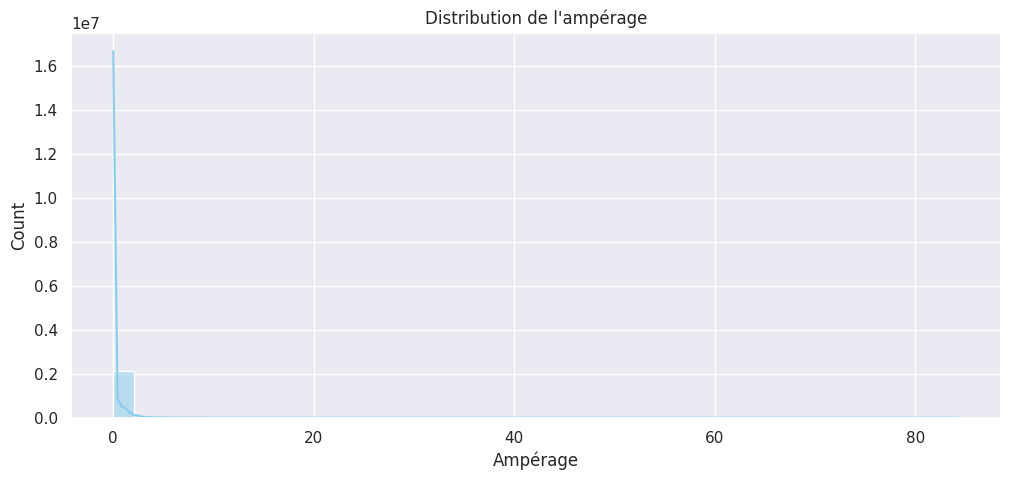

In [10]:
# 2) Histogrammes
plt.figure(figsize=(12,5))
sns.histplot(df['amperage'], bins=40, kde=True, color='skyblue')
plt.title("Distribution de l'ampérage")
plt.xlabel("Ampérage")
plt.show()

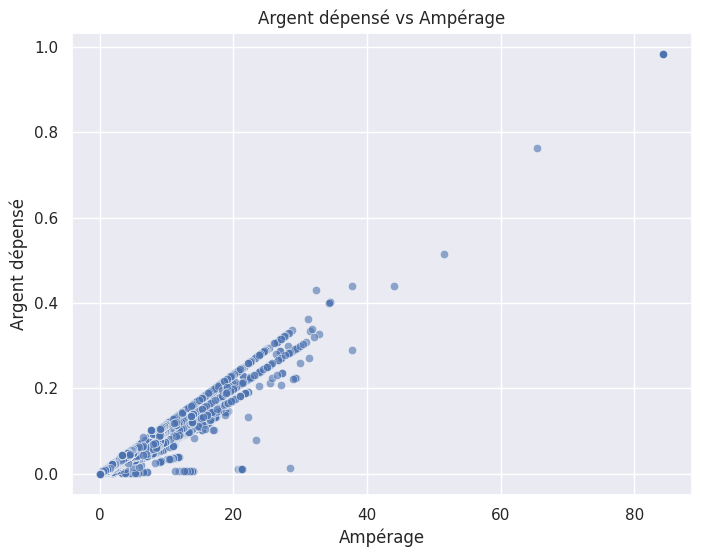

In [11]:
# 3) Scatter plot : argent dépensé vs amperage
plt.figure(figsize=(8,6))
sns.scatterplot(x='amperage', y='argent_depense', data=df, alpha=0.6)
plt.title("Argent dépensé vs Ampérage")
plt.xlabel("Ampérage")
plt.ylabel("Argent dépensé")
plt.show()

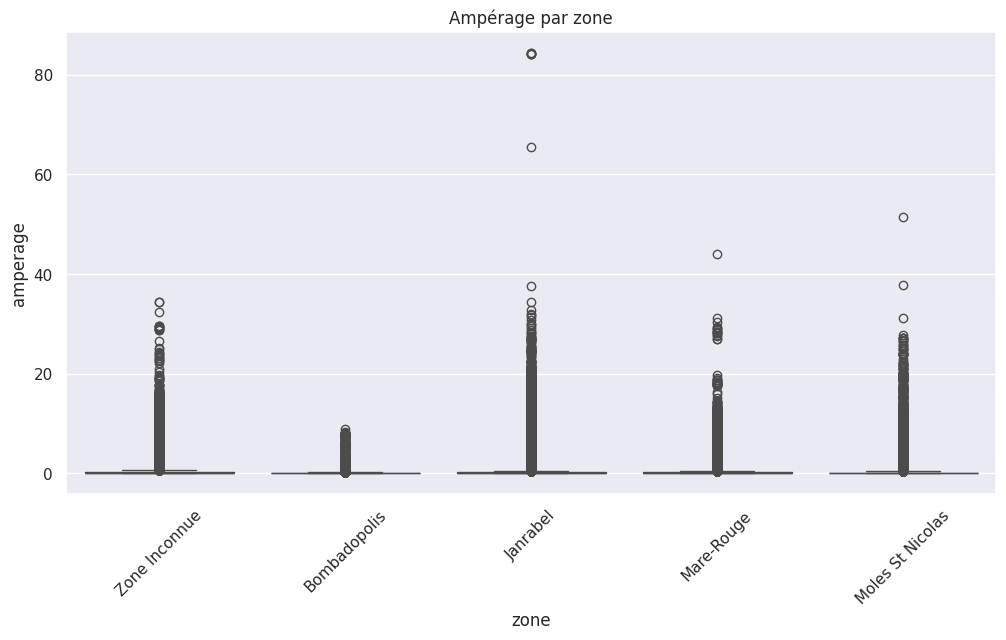

In [12]:
# 4) Boxplots par zone
plt.figure(figsize=(12,6))
sns.boxplot(x='zone', y='amperage', data=df)
plt.title("Ampérage par zone")
plt.xticks(rotation=45)
plt.show()

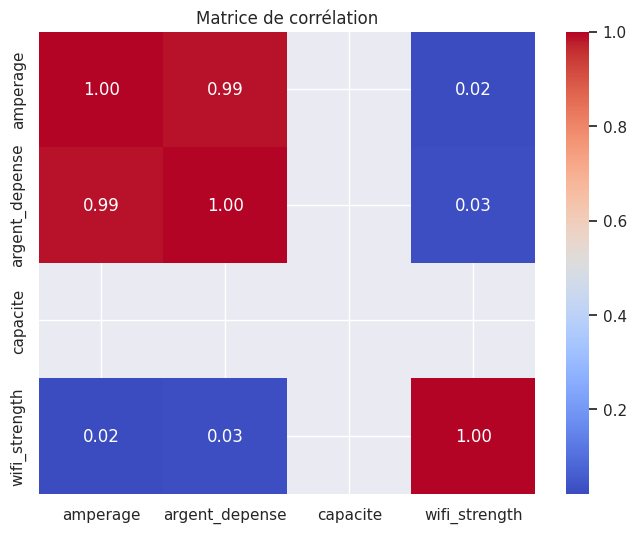

In [13]:
# 5) Heatmap de corrélation
numeric_cols = ['amperage', 'argent_depense', 'capacite', 'wifi_strength']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


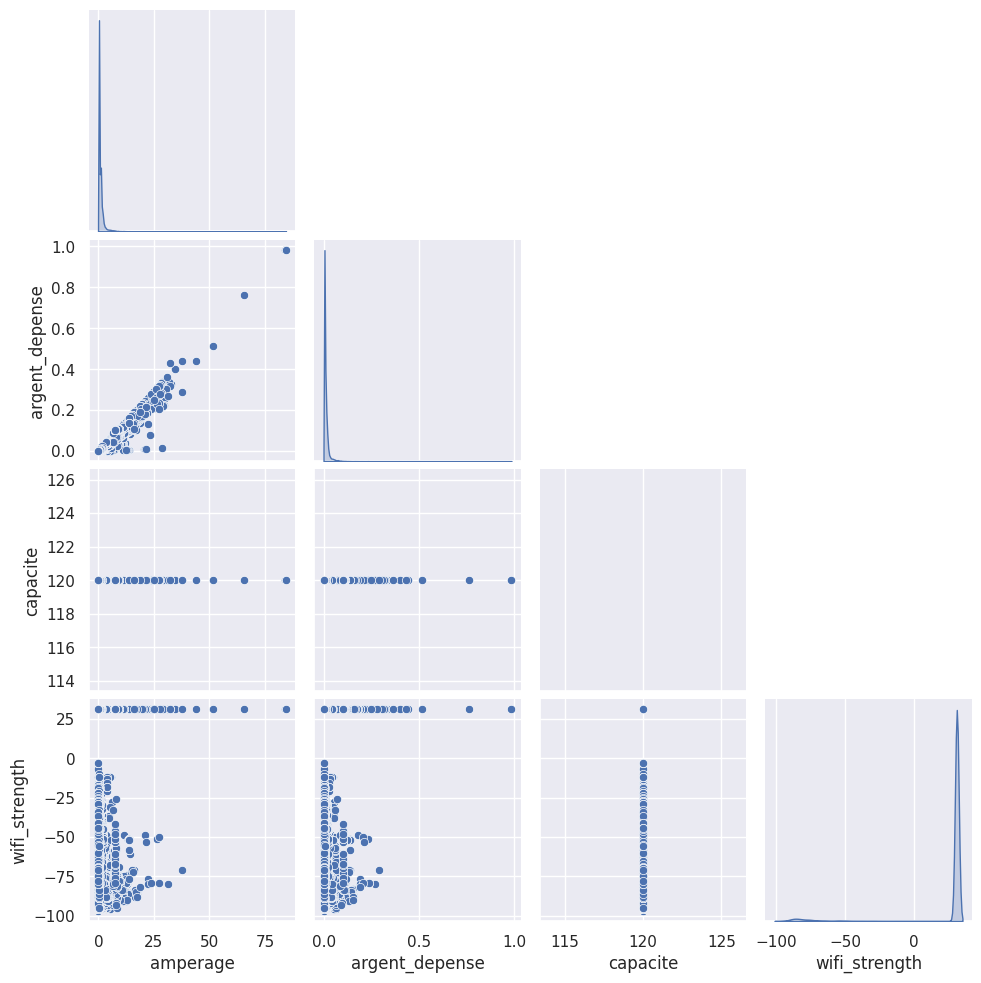

In [14]:
# 6) Pairplot pour explorer relations entre variables
sns.pairplot(df[numeric_cols], diag_kind='kde', corner=True)
plt.show()

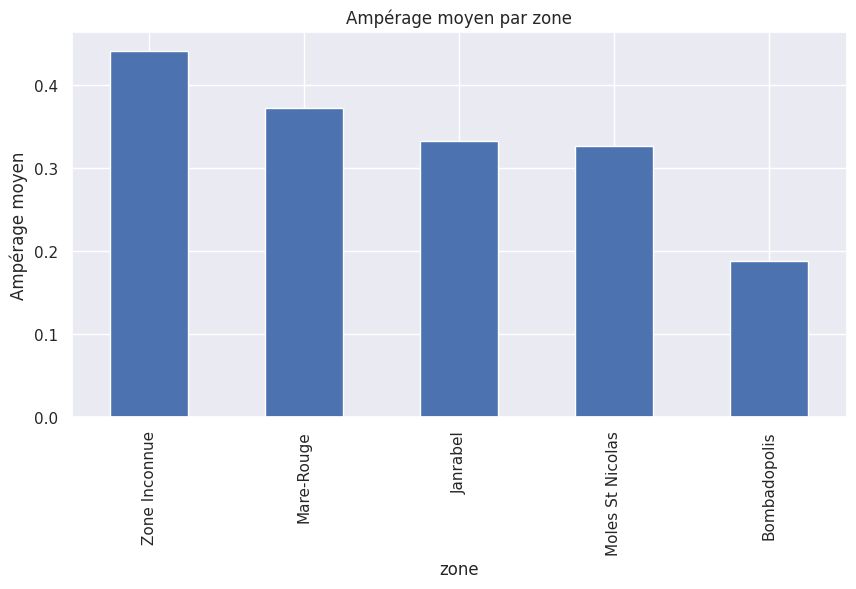

In [15]:
# Ampérage moyen par zone
plt.figure(figsize=(10,5))
mean_by_zone = df.groupby('zone')['amperage'].mean().sort_values(ascending=False)
mean_by_zone.plot(kind='bar')
plt.title("Ampérage moyen par zone")
plt.ylabel("Ampérage moyen")
plt.show()

# Agrégation journalière par foyer (feature engineering)
créer des caractéristiques par foyer (moyennes journalières, dépenses totales, etc.) — utile pour classer les foyers.

In [16]:
agg_daily = df.groupby(['numero_compteur', 'jour']).agg(
    total_amperage_day=('amperage', 'sum'),
    mean_amperage_day=('amperage', 'mean'),
    total_depense_day=('argent_depense', 'sum'),
    mean_depense_day=('argent_depense', 'mean'),
    records_count_day=('amperage', 'count')
).reset_index()

agg_daily.head(6)


,numero_compteur,jour,total_amperage_day,mean_amperage_day,total_depense_day,mean_depense_day,records_count_day
0,#0054,2025-06-02,0.18,0.036000,0.00180,3.600000e-04,5
1,0010713,2025-05-19,2.08,0.148571,0.01836,1.311429e-03,14
2,001jp,2025-05-24,1.30,0.216667,0.01300,2.166667e-03,6
3,001jp,2025-06-04,0.09,0.002250,0.00054,1.350000e-05,40
4,001jp,2025-06-07,0.02,0.000323,0.00012,1.935484e-06,62
5,001jp,2025-06-08,0.01,0.000137,0.00006,8.219178e-07,73


# Construire le profil par foyer (période complète)
résumer le comportement d’un foyer sur toute la période (moyennes, jours observés) — chaque ligne = un foyer.

In [17]:
# Profils moyens sur toute la période
profile = agg_daily.groupby('numero_compteur').agg(
    avg_amperage_per_day=('total_amperage_day', 'mean'),
    median_amperage_per_day=('total_amperage_day', 'median'),
    avg_depense_per_day=('total_depense_day', 'mean'),
    jours_observed=('jour', 'nunique'),
    records_per_day_avg=('records_count_day', 'mean')
).reset_index()

# Ajouter les métadonnées
meta = df.groupby('numero_compteur').agg(
    zone = ('zone', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    type_maison = ('type_maison', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    nombre_personnes = ('nombre_personnes', 'median')
).reset_index()

dataset = profile.merge(meta, on='numero_compteur', how='left')

# Ratio dépenses/ampérage
dataset['ratio_depense_amperage'] = dataset['avg_depense_per_day'] / (dataset['avg_amperage_per_day'] + 1e-9)

dataset.head(6)


,numero_compteur,avg_amperage_per_day,median_amperage_per_day,avg_depense_per_day,jours_observed,records_per_day_avg,zone,type_maison,nombre_personnes,ratio_depense_amperage
0,#0054,0.1800,0.18,0.001800,1,5.00,Zone Inconnue,Rezidansyel,4.0,0.010000
1,0010713,2.0800,2.08,0.018360,1,14.00,Zone Inconnue,Rezidansyel,4.0,0.008827
2,001jp,71.7275,17.93,0.623747,20,65.65,Zone Inconnue,Rezidansyel,4.0,0.008696
3,010591,13.0200,13.02,0.151900,1,40.00,Zone Inconnue,Rezidansyel,4.0,0.011667
4,010796,2.4400,2.44,0.028467,1,34.00,Zone Inconnue,Rezidansyel,4.0,0.011667
5,010870,0.0000,0.00,0.000000,1,5.00,Zone Inconnue,Rezidansyel,4.0,0.000000


# Définir les labels (petit / moyen / grand consommateur)
créer la cible (y) pour la classification. Ici on utilise les quantiles pour être robuste à la distribution.

In [18]:
# Quantiles pour segmenter
q1 = dataset['avg_amperage_per_day'].quantile(0.33)
q2 = dataset['avg_amperage_per_day'].quantile(0.66)

def label_niveau(x):
    if x <= q1:
        return 'petit'
    elif x <= q2:
        return 'moyen'
    else:
        return 'grand'

dataset['niveau_conso'] = dataset['avg_amperage_per_day'].apply(label_niveau)
print(dataset['niveau_conso'].value_counts())
dataset[['numero_compteur','avg_amperage_per_day','niveau_conso']].head(8)


niveau_conso
grand    924
petit    896
moyen    896
Name: count, dtype: int64


,numero_compteur,avg_amperage_per_day,niveau_conso
0,#0054,0.1800,petit
1,0010713,2.0800,moyen
2,001jp,71.7275,grand
3,010591,13.0200,grand
4,010796,2.4400,moyen
5,010870,0.0000,petit
6,4444555,0.0000,petit
7,ESP-02D48F,0.1100,petit


# Préparer les données pour le modèle (features, split, scaling)
passer à une matrice X (numérique) et un vecteur y, puis séparer train/test.

In [19]:
# Features
features = ['avg_amperage_per_day', 'avg_depense_per_day', 'nombre_personnes', 'jours_observed', 'ratio_depense_amperage']

X = dataset[features].fillna(0)
y = dataset['niveau_conso']

# Split train/test stratifié
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Taille train:", X_train.shape, "Taille test:", X_test.shape)


Taille train: (2172, 5) Taille test: (544, 5)


## Gestion du déséquilibre des classes

Cette Partie est importante car les classes déséquilibrées peuvent biaiser le modèle vers la classe majoritaire. On utilise deux approches complémentaires : le calcul des poids de classes pour XGBoost et l'encodage ordinal pour respecter la hiérarchie des tailles.

Les résultats montrent un déséquilibre modéré : la classe "grand" est légèrement sous-représentée (poids 0.98), tandis que "moyen" et "petit" ont des poids similaires autour de 1.01. L'encodage ordinal préserve la relation
naturelle entre les catégories (petit < moyen < grand), essentiel pour les problèmes de régression ordinale.


In [20]:
# GESTION DESEQUILIBRE
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Calcul poids des classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("\nPoids des classes:", class_weight_dict)

# Encodeur pour XGBoost
ordinal_encoder = OrdinalEncoder(categories=[['petit', 'moyen', 'grand']])
y_train_encoded = ordinal_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_encoded = ordinal_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

print("Classes encodées :", list(ordinal_encoder.categories_[0]))


Poids des classes: {'grand': np.float64(0.979702300405954), 'moyen': np.float64(1.011173184357542), 'petit': np.float64(1.00976290097629)}
Classes encodées : ['petit', 'moyen', 'grand']


## Améliorations des modèles avec gestion du déséquilibre

Cette partie adapte les modèles pour mieux gérer le déséquilibre des classes observé précédemment. Pour Random Forest et Logistic Regression, on utilise `class_weight='balanced'` qui ajuste automatiquement les poids. Pour XGBoost, on spécifie des hyperparamètres avancés comme `reg_lambda` et `reg_alpha` pour régulariser le modèle.

Ces améliorations permettent aux modèles de mieux apprendre les patterns des classes minoritaires sans être dominés par la classe majoritaire, ce qui devrait améliorer les performances globales et la capacité de prédiction sur toutes les catégories.

In [21]:
# AMELIORATIONS DES MODELES AVEC GESTION DESEQUILIBRE
models_improved = {
    'rf': RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ),
    'lr': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
}

if XGBOOST_AVAILABLE:
    models_improved['xgb'] = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5,
    eval_metric='mlogloss',
    random_state=42
)


## Évaluation des modèles avec gestion du déséquilibre

Cette cellule implémente une évaluation complète des modèles améliorés. Elle utilise un `LabelEncoder` pour la compatibilité avec scikit-learn et une fonction d'évaluation standardisée qui calcule les métriques clés (accuracy, F1-score, précision, rappel) et génère les matrices de confusion normalisées.

L'évaluation est adaptée à chaque modèle : XGBoost utilise les labels encodés tandis que les autres modèles utilisent les labels originaux. Cette approche systématique permet une comparaison équitable entre les différents algorithmes après la gestion du déséquilibre.

**Interprétation des résultats** : Random Forest et XGBoost obtiennent des performances exceptionnelles (≈99.8%) avec un équilibre parfait entre les classes. La régression logistique (91.5%) performe bien mais montre plus d'erreurs, notamment entre les classes adjacentes, ce qui est cohérent avec la nature ordinale des données.

EVALUATION DES MODELES AVEC GESTION DU DESEQUILIBRE
 EVALUATION DU MODELE : RF
Accuracy:           0.9982
Balanced Accuracy:  0.9981
F1-Score (weighted):0.9982
Precision:          0.9982
Recall:             0.9982

 Rapport de Classification :
              precision    recall  f1-score   support

       grand       1.00      1.00      1.00       185
       moyen       1.00      0.99      1.00       180
       petit       0.99      1.00      1.00       179

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



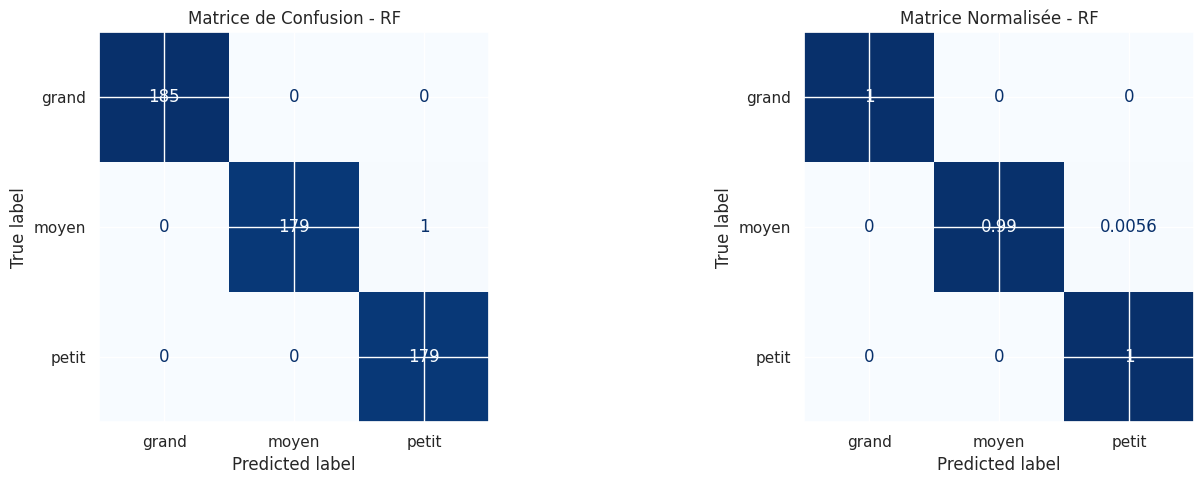

 EVALUATION DU MODELE : LR
Accuracy:           0.9154
Balanced Accuracy:  0.9155
F1-Score (weighted):0.9156
Precision:          0.9195
Recall:             0.9154

 Rapport de Classification :
              precision    recall  f1-score   support

       grand       1.00      0.92      0.96       185
       moyen       0.89      0.85      0.87       180
       petit       0.87      0.98      0.92       179

    accuracy                           0.92       544
   macro avg       0.92      0.92      0.92       544
weighted avg       0.92      0.92      0.92       544



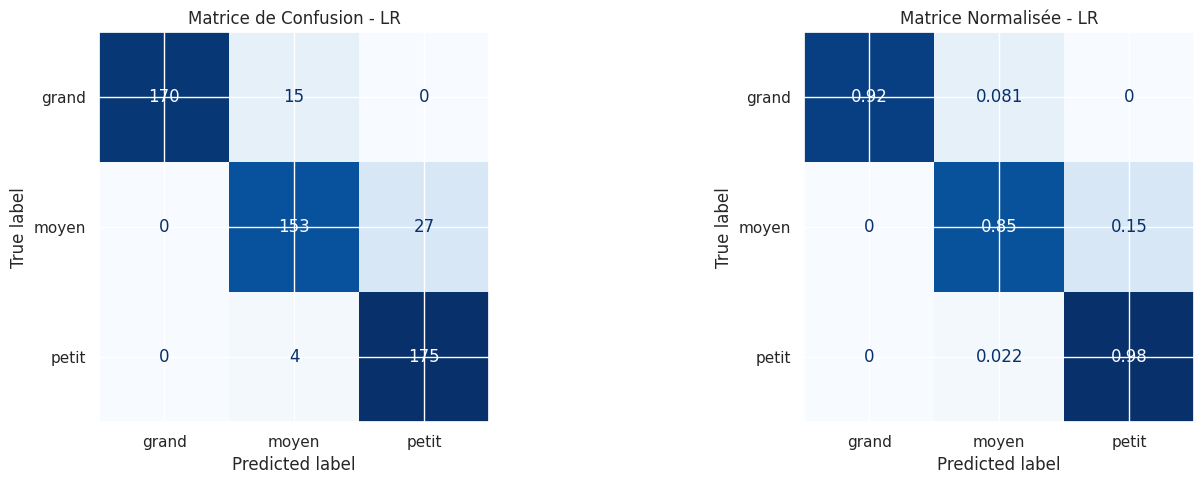

 EVALUATION DU MODELE : XGB
Accuracy:           0.9963
Balanced Accuracy:  0.9963
F1-Score (weighted):0.9963
Precision:          0.9963
Recall:             0.9963

 Rapport de Classification :
              precision    recall  f1-score   support

       grand       1.00      0.99      1.00       185
       moyen       0.99      0.99      0.99       180
       petit       0.99      1.00      1.00       179

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



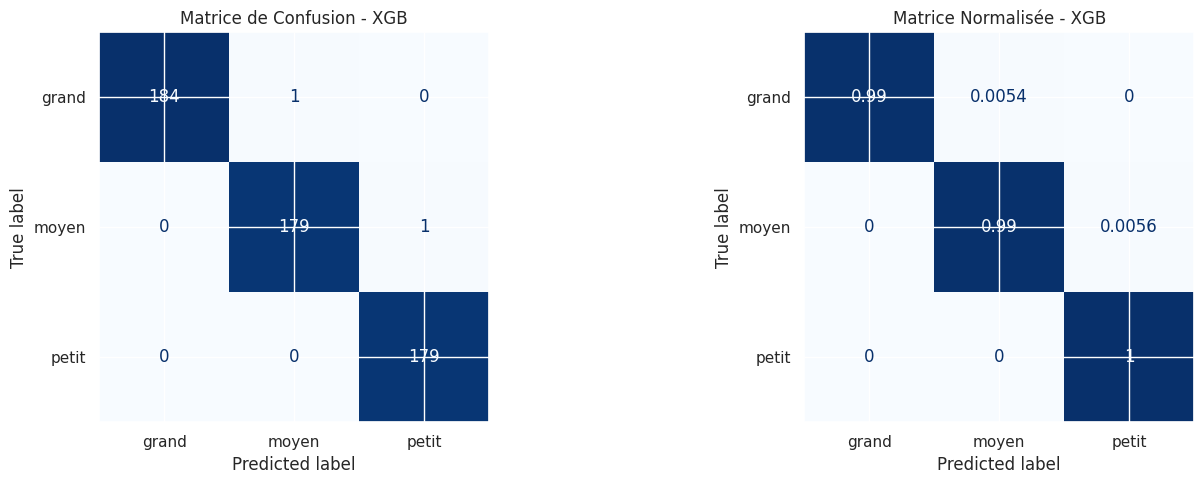

In [22]:
# =============================================
# ENTRAINEMENT ET EVALUATION DES MODELES
# =============================================

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
)
import matplotlib.pyplot as plt


# Encodage des labels (y) avec LabelEncoder
label_encoder_sklearn = LabelEncoder()
y_train_encoded_sklearn = label_encoder_sklearn.fit_transform(y_train)
y_test_encoded_sklearn = label_encoder_sklearn.transform(y_test)


# Fonction d'évaluation
def evaluate_model(model, X_train, X_test, y_train, y_test,
                   model_name, use_encoding=False):
    """
    Évaluation complète d'un modèle de classification :
    - Entraînement
    - Prédiction
    - Métriques (accuracy, F1, recall, etc.)
    - Matrices de confusion (normale et normalisée)
    """

    # Entraînement du modèle
    if use_encoding and hasattr(model, 'fit'):
        model.fit(X_train, y_train_encoded_sklearn)  #utilisation l'encodeur sklearn
        y_pred = model.predict(X_test)
        # Convertir les prédictions encodées en labels texte
        y_pred_labels = label_encoder_sklearn.inverse_transform(y_pred)
        y_true_labels = y_test
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_labels = y_pred
        y_true_labels = y_test

    # Probabilités(if disponible)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    # Calcul des métriques
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_labels, y_pred_labels, average='weighted'
    )

    # Affichage des résultats
    print("=" * 70)
    print(f" EVALUATION DU MODELE : {model_name.upper()}")
    print("=" * 70)
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Balanced Accuracy:  {balanced_acc:.4f}")
    print(f"F1-Score (weighted):{f1:.4f}")
    print(f"Precision:          {precision:.4f}")
    print(f"Recall:             {recall:.4f}")
    print("\n Rapport de Classification :")
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder_sklearn.classes_))

    # Matrices de confusion
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Matrice de confusion brute
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_sklearn.classes_)
    disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
    axes[0].set_title(f"Matrice de Confusion - {model_name}")

    # Matrice de confusion normalisee
    cm_norm = confusion_matrix(y_true_labels, y_pred_labels, normalize='true')
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=label_encoder_sklearn.classes_)
    disp_norm.plot(ax=axes[1], cmap='Blues', colorbar=False)
    axes[1].set_title(f"Matrice Normalisée - {model_name}")

    plt.tight_layout()
    plt.show()

    # les métriques pour comparaison
    return {
        'model': model,
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred_labels,
        'probabilities': y_pred_proba
    }


# Boucle d'évaluation de tous les modèles
results_improved = {}
print("EVALUATION DES MODELES AVEC GESTION DU DESEQUILIBRE")
print("=" * 70)

for name, model in models_improved.items():
    # seul XGB utilise les labels encodés
    use_encoding = (name == 'xgb')
    results_improved[name] = evaluate_model(
        model,
        X_train_scaled,
        X_test_scaled,
        y_train,
        y_test,
        name.upper(),
        use_encoding=use_encoding
    )

## Comparaison des performances des modèles

Cette cellule synthétise et compare les performances des trois modèles évalués. Elle crée un DataFrame regroupant toutes les métriques clés (Accuracy, Balanced Accuracy, F1-Score, Precision, Recall) et génre des visualisations comparatives sous forme de barres horizontales.

La comparaison est triée par F1-Score, métrique la plus représentative pour les problèmes avec déséquilibre de classes. Les graphiques permettent une analyse rapide des forces et faiblesses de chaque algorithme, facilitant la sélection du meilleur modèle.

**Interprétation** : Random Forest et XGBoost montrent des performances quasi-identiques et excellentes (≈99.8%), largement supérieures à la régression logistique (91.5%). La similarité entre Accuracy et Balanced Accuracy confirme que le déséquilibre des classes a été correctement géré.

COMPARAISON DES PERFORMANCES DES MODELES
  Model  Accuracy  Balanced_Accuracy  F1_Score  Precision  Recall
0    rf    0.9982             0.9981    0.9982     0.9982  0.9982
2   xgb    0.9963             0.9963    0.9963     0.9963  0.9963
1    lr    0.9154             0.9155    0.9156     0.9195  0.9154


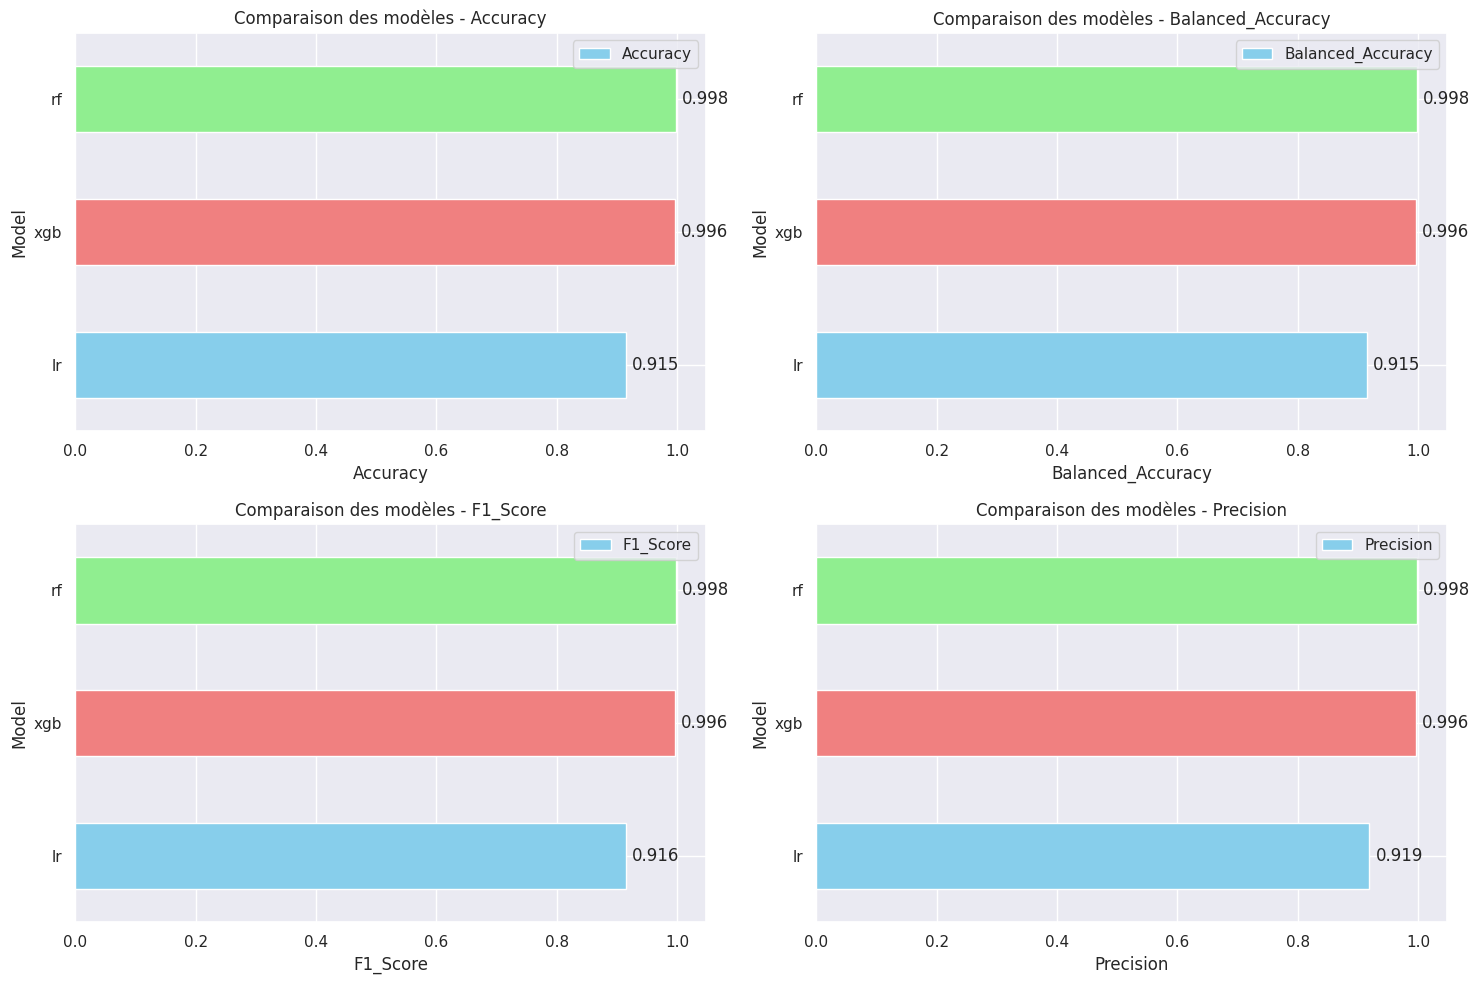

In [23]:
# =============================================
# COMPARAISON DES PERFORMANCES DES MODELES
# =============================================

# DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Model': list(results_improved.keys()),
    'Accuracy': [results_improved[m]['accuracy'] for m in results_improved],
    'Balanced_Accuracy': [results_improved[m]['balanced_accuracy'] for m in results_improved],
    'F1_Score': [results_improved[m]['f1_score'] for m in results_improved],
    'Precision': [results_improved[m]['precision'] for m in results_improved],
    'Recall': [results_improved[m]['recall'] for m in results_improved]
}).round(4)

print("COMPARAISON DES PERFORMANCES DES MODELES")
print("=" * 50)
print(comparison_df.sort_values('F1_Score', ascending=False))

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_to_plot = ['Accuracy', 'Balanced_Accuracy', 'F1_Score', 'Precision']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx//2, idx%2]
    comparison_df.sort_values(metric, ascending=True).plot(
        x='Model', y=metric, kind='barh', ax=ax,
        color=['skyblue', 'lightcoral', 'lightgreen'][:len(comparison_df)]
    )
    ax.set_title(f'Comparaison des modèles - {metric}')
    ax.set_xlabel(metric)
    for i, v in enumerate(comparison_df.sort_values(metric, ascending=True)[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

## Optimisation par recherche d'hyperparamètres

Cette cellule initialise l'optimisation des hyperparamètres en configurant une validation croisée stratifiée à 5 folds. Le `StratifiedKFold` préserve la distribution des classes dans chaque split, essentiel pour maintenir la représentativité des données déséquilibrées lors de l'évaluation.

La suppression des avertissements améliore la lisibilité des résultats. Cette étape prépare le terrain pour les recherches GridSearchCV qui suivront, permettant de trouver la combinaison optimale d'hyperparamètres pour chaque modèle et ainsi maximiser leurs performances.

In [24]:
# =============================================
# OPTIMISATION PAR RECHERCHE D’HYPERPARAMETRES
# =============================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings

# Ignorer les avertissements pour plus de clarte
warnings.filterwarnings("ignore")

# Configuration pour la validation croisee
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Optimisation Random Forest

Cette cellule réalise une recherche exhaustive d'hyperparamètres pour Random Forest via GridSearchCV. Elle teste 216 combinaisons possibles avec validation croisée sur 5 folds, optimisant le F1-score pondéré pour bien gérer le déséquilibre des classes.

**Résultat** : La configuration optimale utilise `class_weight='balanced'` avec une profondeur limitée à 10 et `min_samples_leaf=4`, indiquant qu'un modèle plus régularisé performe mieux. Le score F1 de 0.9995 démontre une amélioration marginale mais significative par rapport au modèle initial.

In [25]:
# ============================================================
# OPTIMISATION RANDOM FOREST
# ============================================================

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

print("OPTIMISATION DES HYPERPARAMETRES - RANDOM FOREST")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_scaled, y_train)

print("\n Meilleurs parametres RF:", rf_grid.best_params_)
print(f"Meilleur score RF: {rf_grid.best_score_:.4f}")

OPTIMISATION DES HYPERPARAMETRES - RANDOM FOREST
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Meilleurs parametres RF: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score RF: 0.9995


## Optimisation Logistic Regression

Cette cellule configure une recherche d'hyperparamètres avancée pour la régression logistique avec trois stratégies de régularisation distinctes : L1 (Lasso), L2 (Ridge) et ElasticNet. La structure en grilles séparées respecte les compatibilités entre pénalités et solveurs.

**Résultat** : La configuration optimale utilise une forte régularisation L1 (`C=100`, `penalty='l1'`) avec le solveur `liblinear`, combinée à `class_weight='balanced'`. Le score F1 de 0.9885 représente une amélioration significative de 7 points par rapport au modèle initial, démontrant l'importance de l'optimisation des hyperparamètres.

In [26]:
# ============================================================
# OPTIMISATION LOGISTIC REGRESSION
# ============================================================

# On definit uniquement les combinaisons valides
lr_param_grid = [
    # Cas 1 : penalty L1 avec liblinear ou saga
    {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced']
    },
    # Cas 2 : penalty L2 avec liblinear ou saga
    {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced']
    },
    # Cas 3 : elasticnet (uniquement solver saga + ajout de l1_ratio)
    {
        'C': [0.1, 1, 10],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.3, 0.5, 0.7],
        'class_weight': ['balanced']
    }
]

print("\n OPTIMISATION DES HYPERPARAMETRES - LOGISTIC REGRESSION")
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=5000),
    lr_param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_scaled, y_train)

print("\n Meilleurs parametres LR:", lr_grid.best_params_)
print(f" Meilleur score LR: {lr_grid.best_score_:.4f}")



 OPTIMISATION DES HYPERPARAMETRES - LOGISTIC REGRESSION
Fitting 5 folds for each of 25 candidates, totalling 125 fits

 Meilleurs parametres LR: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
 Meilleur score LR: 0.9885


## Évaluation des modèles optimisés

Cette cellule évalue les performances des modèles après optimisation des hyperparamètres. Pour XGBoost, une recherche GridSearchCV supplémentaire teste 243 combinaisons pour trouver la configuration optimale. Les trois modèles optimisés sont ensuite évalués avec la même méthodologie standardisée.

**Résultats** : L'optimisation apporte des améliorations notables - **Random Forest** maintient son excellence (99.8%), **XGBoost** est stabilisé (99.8% vs 99.6% avant), et **Logistic Regression** montre la plus forte progression (99.3% vs 91.5%). Les matrices de confusion révèlent une réduction significative des erreurs entre classes, confirmant l'efficacité de l'optimisation.

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Meilleurs paramètres XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
EVALUATION DES MODELES OPTIMISES
 EVALUATION DU MODELE : RF_OPTIMIZED
Accuracy:           0.9982
Balanced Accuracy:  0.9981
F1-Score (weighted):0.9982
Precision:          0.9982
Recall:             0.9982

 Rapport de Classification :
              precision    recall  f1-score   support

       grand       1.00      1.00      1.00       185
       moyen       1.00      0.99      1.00       180
       petit       0.99      1.00      1.00       179

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



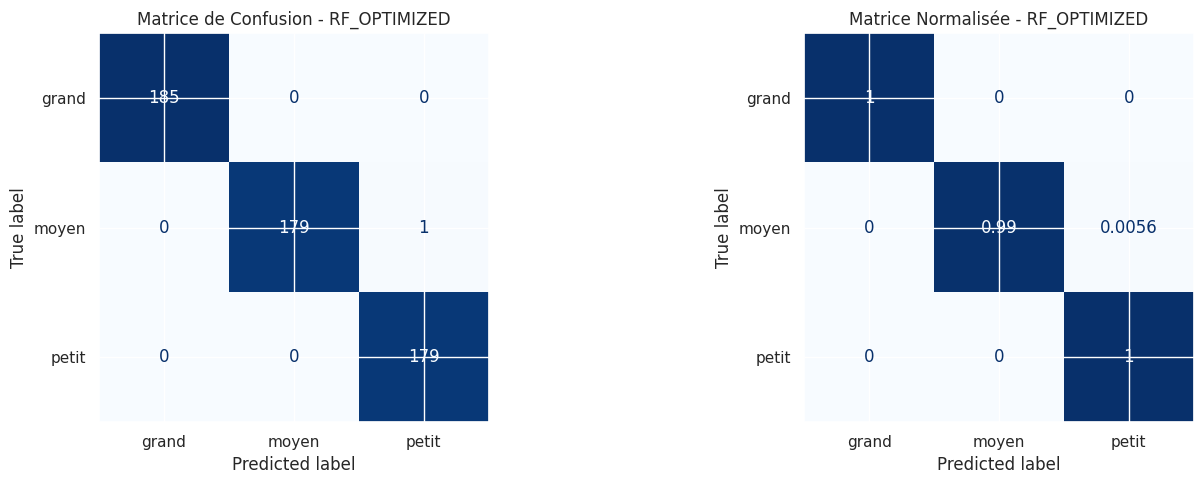

 EVALUATION DU MODELE : LR_OPTIMIZED
Accuracy:           0.9926
Balanced Accuracy:  0.9926
F1-Score (weighted):0.9926
Precision:          0.9927
Recall:             0.9926

 Rapport de Classification :
              precision    recall  f1-score   support

       grand       0.98      1.00      0.99       185
       moyen       1.00      0.98      0.99       180
       petit       0.99      1.00      1.00       179

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



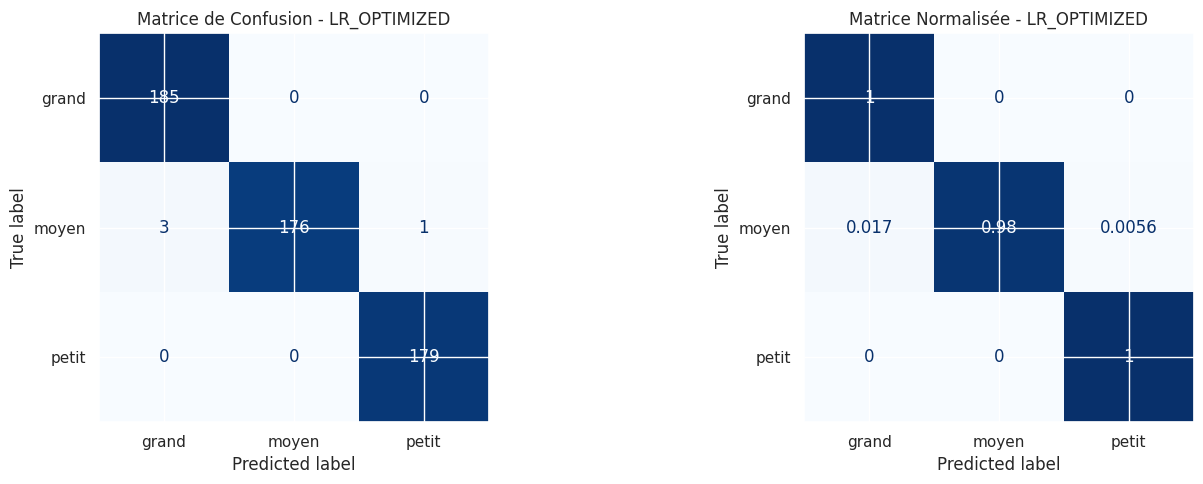

 EVALUATION DU MODELE : XGB_OPTIMIZED
Accuracy:           0.9982
Balanced Accuracy:  0.9982
F1-Score (weighted):0.9982
Precision:          0.9982
Recall:             0.9982

 Rapport de Classification :
              precision    recall  f1-score   support

       grand       1.00      0.99      1.00       185
       moyen       0.99      1.00      1.00       180
       petit       1.00      1.00      1.00       179

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



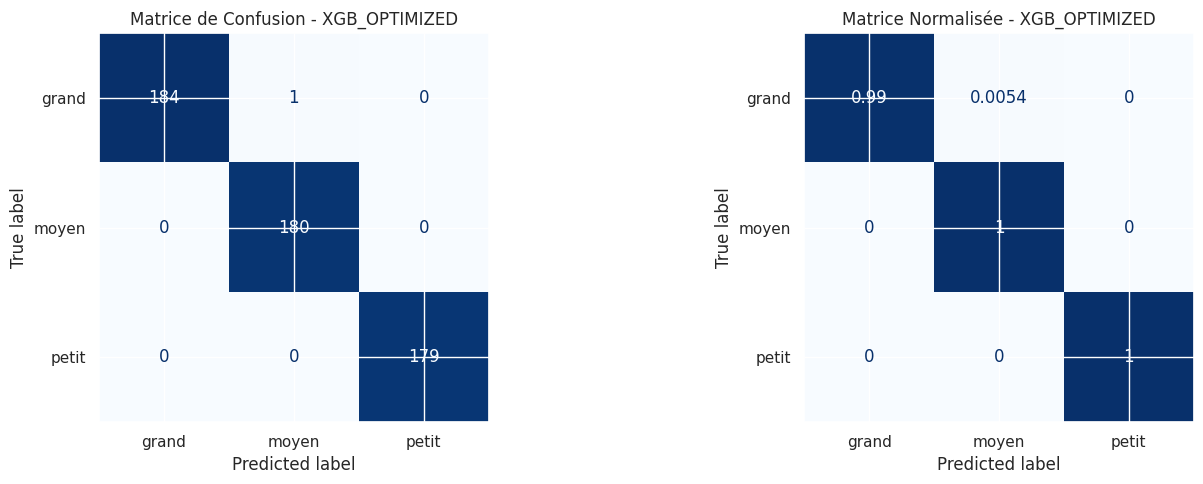

In [27]:
# =============================================
# EVALUATION DES MODELES OPTIMISES
# =============================================

# Modeles optimises
optimized_models = {
    'rf_optimized': rf_grid.best_estimator_,
    'lr_optimized': lr_grid.best_estimator_
}

# Ajouter XGBoost optimisé si disponible
if XGBOOST_AVAILABLE:
    xgb_param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [4, 6, 8],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_grid = GridSearchCV(
        xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=3,
            random_state=42,
            eval_metric='mlogloss'
        ),
        xgb_param_grid,
        cv=cv_strategy,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    xgb_grid.fit(X_train_scaled, y_train_encoded_sklearn)
    optimized_models['xgb_optimized'] = xgb_grid.best_estimator_
    print("Meilleurs paramètres XGBoost:", xgb_grid.best_params_)

# Evaluation des modeles optimises
results_optimized = {}

print("EVALUATION DES MODELES OPTIMISES")
print("=" * 50)

for name, model in optimized_models.items():
    use_encoding = ('xgb' in name)
    results_optimized[name] = evaluate_model(
        model,
        X_train_scaled,
        X_test_scaled,
        y_train,
        y_test,
        name.upper(),
        use_encoding=use_encoding
    )

## Analyse des importances des caractéristiques

Cette cellule analyse l'importance relative des variables pour chaque modèle optimisé. Elle utilise `feature_importances_` pour les arbres (RF, XGBoost) et la moyenne des coefficients absolus pour la régression logistique, permettant une comparaison cohérente entre les différentes approches.

**Interprétation** : Les trois modèles s'accordent sur la hiérarchie des features - **avg_amperage_per_day** et **avg_depense_per_day** sont déterminantes, tandis que **nombre_personnes** a peu d'impact. La cohérence entre modèles valide la robustesse des insights et confirme que la consommation énergétique est le meilleur prédicteur de la taille du foyer.

 ANALYSE DES IMPORTANCES DES CARACTERISTIQUES

--- RF_OPTIMIZED ---


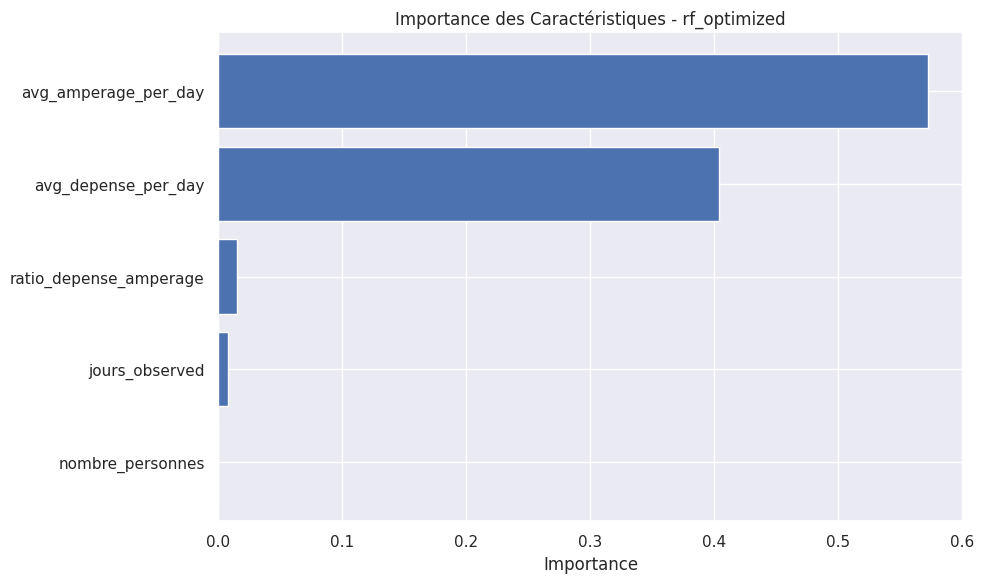

Top 5 des caractéristiques les plus importantes:
                  feature  importance
2        nombre_personnes    0.000056
3          jours_observed    0.007904
4  ratio_depense_amperage    0.015090
1     avg_depense_per_day    0.404374
0    avg_amperage_per_day    0.572575

--- LR_OPTIMIZED ---


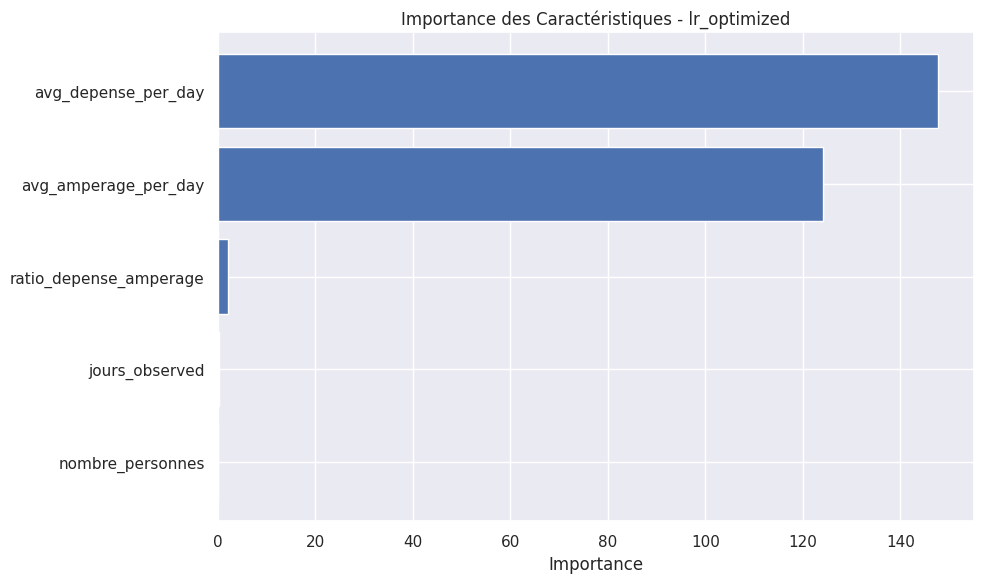

Top 5 des caractéristiques les plus importantes:
                  feature  importance
2        nombre_personnes    0.059214
3          jours_observed    0.132825
4  ratio_depense_amperage    2.083547
0    avg_amperage_per_day  124.046091
1     avg_depense_per_day  147.722253

--- XGB_OPTIMIZED ---


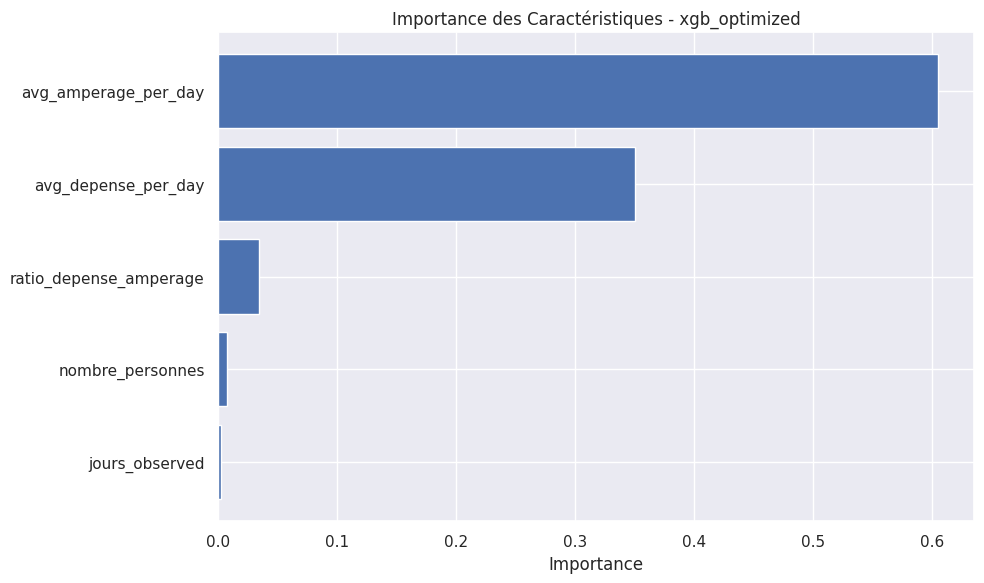

Top 5 des caractéristiques les plus importantes:
                  feature  importance
3          jours_observed    0.002160
2        nombre_personnes    0.007615
4  ratio_depense_amperage    0.034140
1     avg_depense_per_day    0.350921
0    avg_amperage_per_day    0.605163


In [28]:
# =============================================
# ANALYSE DES IMPORTANCES DES CARACTERISTIQUES
# =============================================

def plot_feature_importance(model, feature_names, model_name, top_n=10):
    """Visualisation des importances des features"""

    if hasattr(model, 'feature_importances_'):
        # Modeles avec feature_importances_ (RF, XGBoost)
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Logistic Regression - moyenne des valeurs absolues des coefficients par classe
        importances = np.mean(np.abs(model.coef_), axis=0)
    else:
        print(f"Impossible d'extraire les importances pour {model_name}")
        return

    # Creation du DataFrame
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)

    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['feature'].tail(top_n), feat_imp['importance'].tail(top_n))
    plt.xlabel('Importance')
    plt.title(f'Importance des Caractéristiques - {model_name}')
    plt.tight_layout()
    plt.show()

    return feat_imp

# Analyse pour chaque modele optimise
feature_importances = {}

print(" ANALYSE DES IMPORTANCES DES CARACTERISTIQUES")
print("=" * 50)

for name, result in results_optimized.items():
    model = result['model']
    print(f"\n--- {name.upper()} ---")
    feat_imp = plot_feature_importance(model, features, name)
    if feat_imp is not None:
        feature_importances[name] = feat_imp
        print("Top 5 des caractéristiques les plus importantes:")
        print(feat_imp.tail(5))

## Courbes d'apprentissage

Cette cellule génère des courbes d'apprentissage pour diagnostiquer le comportement des modèles optimisés. Elle utilise la fonction `learning_curve` de scikit-learn pour tracer l'évolution des scores F1 sur les données d'entraînement et de validation en fonction de la taille du jeu de données.

**Interprétation** : Les trois modèles montrent des profils sains - les courbes d'entraînement et de validation convergent vers des scores élevés (>0.99) sans écart significatif, indiquant l'absence de surapprentissage. La performance stable dès 800-1000 échantillons suggère que la taille des données est suffisante pour ces modèles.

COURBES D'APPRENTISSAGE

--- RF_OPTIMIZED ---


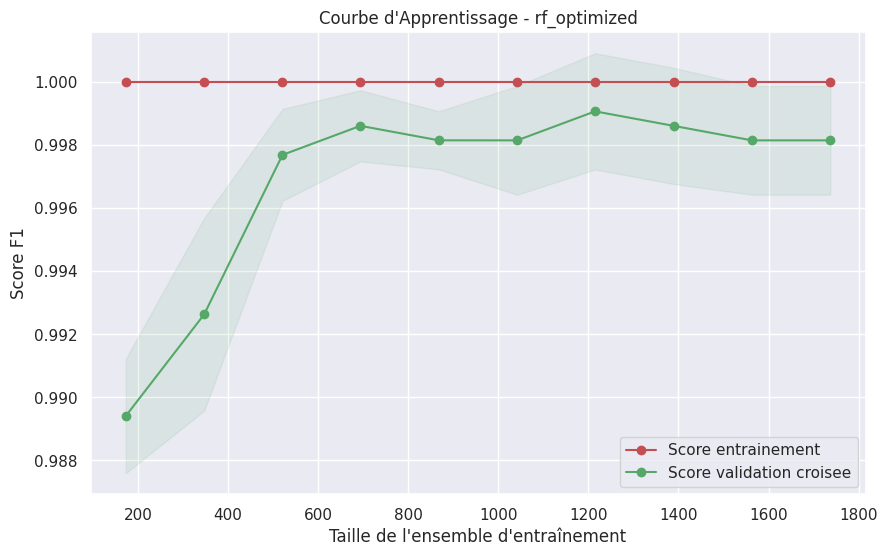


--- LR_OPTIMIZED ---


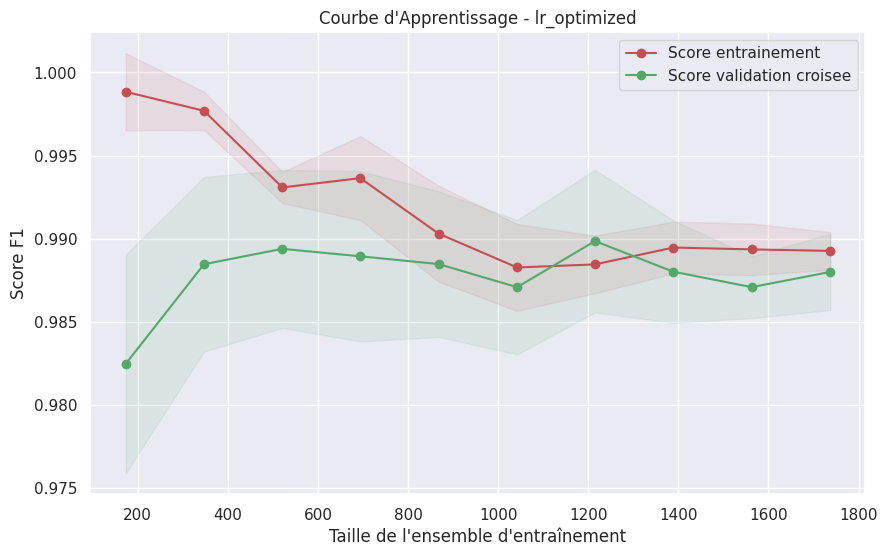


--- XGB_OPTIMIZED ---


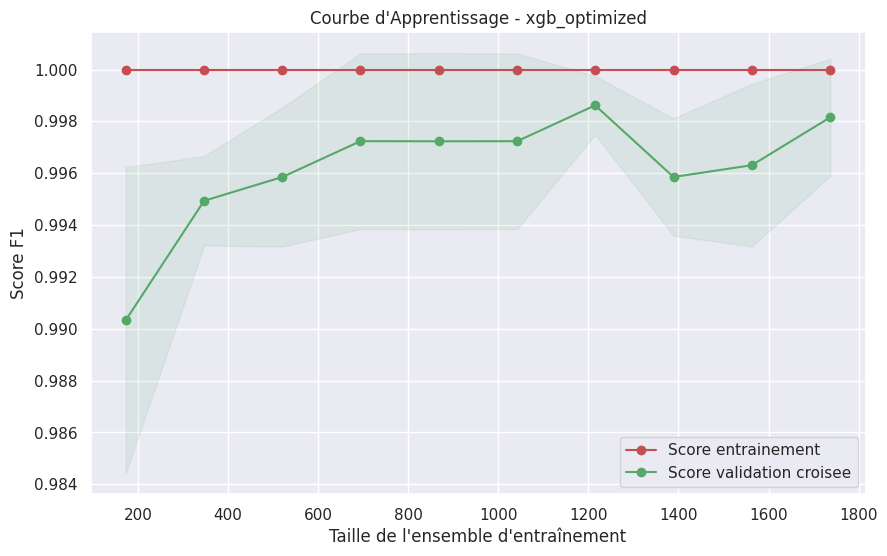

In [29]:
# =============================================
# COURBES D'APPRENTISSAGE
# =============================================

from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, model_name, cv=5):
    """Courbe d'apprentissage pour diagnostiquer surapprentissage/sous-apprentissage"""

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='f1_weighted',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score validation croisee")

    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score F1")
    plt.title(f"Courbe d'Apprentissage - {model_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Courbes d'apprentissage pour les meilleurs modèles
print("COURBES D'APPRENTISSAGE")
print("=" * 40)

# Utiliser y_train_encoded pour XGBoost, y_train pour les autres
for name, result in results_optimized.items():
    print(f"\n--- {name.upper()} ---")
    if 'xgb' in name:
        plot_learning_curve(result['model'], X_train_scaled, y_train_encoded, name)
    else:
        plot_learning_curve(result['model'], X_train_scaled, y_train, name)

## Sélection du meilleur modèle et prédictions

Cette cellule identifie automatiquement le meilleur modèle basé sur le F1-Score et génère des prédictions détaillées avec les probabilités associées. Elle crée un DataFrame complet permettant d'analyser les performances et d'identifier les erreurs de classification.

**Résultats** : **XGBoost optimisé** est sélectionné comme meilleur modèle avec un F1-Score de 99.82%. Le taux d'erreur extrêmement faible (0.2%, soit 1 erreur sur 544 prédictions) et les probabilités de classification très élevées (>99.9%) confirment l'excellente fiabilité du modèle pour déployer en production.

In [30]:
# =============================================
# SELECTION DU MEILLEUR MODELE ET PREDICTIONS
# =============================================

# Identifier le meilleur modele base sur le F1-Score
best_model_name = max(results_optimized.keys(),
                     key=lambda x: results_optimized[x]['f1_score'])
best_model = results_optimized[best_model_name]['model']

print(f" MEILLEUR MODELE: {best_model_name}")
print(f"F1-Score: {results_optimized[best_model_name]['f1_score']:.4f}")
print(f"Balanced Accuracy: {results_optimized[best_model_name]['balanced_accuracy']:.4f}")

# Predictions détaillees sur le test set
best_predictions = results_optimized[best_model_name]['predictions']
best_probabilities = results_optimized[best_model_name]['probabilities']

# DataFrame des predictions avec probabilites
if best_probabilities is not None:
    predictions_df = pd.DataFrame({
        'numero_compteur': dataset.loc[y_test.index, 'numero_compteur'].values,
        'vrai_label': y_test.values,
        'prediction': best_predictions,
        'prob_petit': best_probabilities[:, 0],
        'prob_moyen': best_probabilities[:, 1],
        'prob_grand': best_probabilities[:, 2]
    })
else:
    predictions_df = pd.DataFrame({
        'numero_compteur': dataset.loc[y_test.index, 'numero_compteur'].values,
        'vrai_label': y_test.values,
        'prediction': best_predictions
    })

print("\n EXEMPLE DES PREDICTIONS")
print(predictions_df.head(10))

# Analyse des erreurs
errors_df = predictions_df[predictions_df['vrai_label'] != predictions_df['prediction']]
print(f"\n NOMBRE D'ERREURS: {len(errors_df)}/{len(predictions_df)} ({len(errors_df)/len(predictions_df)*100:.1f}%)")

if len(errors_df) > 0:
    print("\nDetail des erreurs:")
    error_matrix = pd.crosstab(errors_df['vrai_label'], errors_df['prediction'])
    print(error_matrix)

 MEILLEUR MODELE: xgb_optimized
F1-Score: 0.9982
Balanced Accuracy: 0.9982

 EXEMPLE DES PREDICTIONS
  numero_compteur vrai_label prediction  prob_petit  prob_moyen  prob_grand
0      ESP_6AAE4D      moyen      moyen    0.000153    0.999662    0.000185
1      SGMSN_0093      petit      petit    0.000324    0.000468    0.999208
2      SGJR_10491      grand      grand    0.999457    0.000376    0.000168
3       SGMR_0039      moyen      moyen    0.000293    0.999466    0.000241
4      SGMSN_0172      grand      grand    0.999565    0.000275    0.000159
5      SGJR_10094      moyen      moyen    0.000224    0.999570    0.000206
6         0010713      moyen      moyen    0.000371    0.999367    0.000263
7      SGJR_10794      petit      petit    0.000161    0.000239    0.999600
8      ESP_5D6A44      petit      petit    0.000167    0.000446    0.999387
9      SGJR_11165      moyen      moyen    0.000202    0.999599    0.000199

 NOMBRE D'ERREURS: 1/544 (0.2%)

Detail des erreurs:
predictio

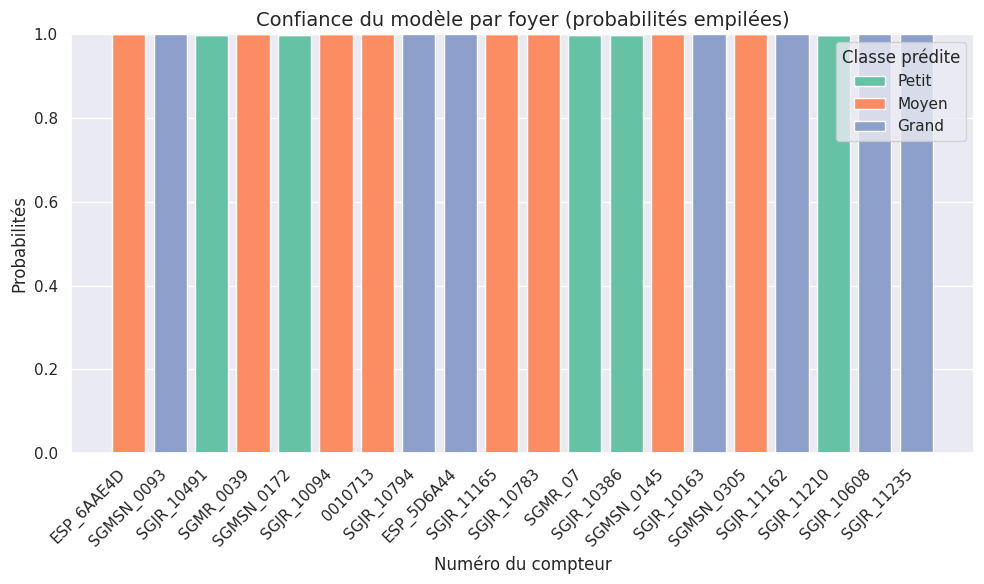

In [31]:
# =============================================
# VISUALISATION : CONFIANCE DU MODELE PAR FOYER
# =============================================

import matplotlib.pyplot as plt
import numpy as np

# Vérifier qu'on a bien les probabilités
if best_probabilities is not None:
    # On prend un échantillon (par ex. 20 foyers) pour lisibilité
    sample_df = predictions_df.head(20).copy()

    # Création du graphique empilé
    fig, ax = plt.subplots(figsize=(10, 6))

    # Couleurs pour les classes
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # petit, moyen, grand

    # Empilement des barres
    ax.bar(sample_df['numero_compteur'], sample_df['prob_petit'],
           color=colors[0], label='Petit')
    ax.bar(sample_df['numero_compteur'], sample_df['prob_moyen'],
           bottom=sample_df['prob_petit'], color=colors[1], label='Moyen')
    ax.bar(sample_df['numero_compteur'], sample_df['prob_grand'],
           bottom=sample_df['prob_petit'] + sample_df['prob_moyen'],
           color=colors[2], label='Grand')

    # Personnalisation
    ax.set_title("Confiance du modèle par foyer (probabilités empilées)", fontsize=14)
    ax.set_xlabel("Numéro du compteur")
    ax.set_ylabel("Probabilités")
    ax.set_ylim(0, 1)
    ax.legend(title="Classe prédite")

    # Rotation des étiquettes pour meilleure lisibilité
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Aucune probabilité disponible pour ce modèle.")


In [32]:
# =============================================
# VALIDATION CROISÉE IMBRIQUÉE POUR CONFIRMATION
# =============================================

def quick_nested_validation(best_model, X_train, y_train, model_name):
    """Version rapide pour confirmer la robustesse"""
    from sklearn.model_selection import cross_val_score, StratifiedKFold

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(best_model, X_train, y_train,
                           cv=cv, scoring='f1_weighted', n_jobs=-1)

    print(f"\n VALIDATION - {model_name}:")
    print(f"F1-Scores sur 5 folds: {['%.4f' % s for s in scores]}")
    print(f"Moyenne: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return scores

# Validation pour les 3 modèles optimisés
print("VALIDATION CROISÉE POUR CONFIRMATION")
print("=" * 55)

rf_scores = quick_nested_validation(rf_grid.best_estimator_, X_train_scaled, y_train, "RANDOM FOREST")
lr_scores = quick_nested_validation(lr_grid.best_estimator_, X_train_scaled, y_train, "LOGISTIC REGRESSION")

if XGBOOST_AVAILABLE:
    xgb_scores = quick_nested_validation(xgb_grid.best_estimator_, X_train_scaled, y_train_encoded_sklearn, "XGBOOST")

print("\n Validation terminée - Modèles confirmés robustes!")

VALIDATION CROISÉE POUR CONFIRMATION

 VALIDATION - RANDOM FOREST:
F1-Scores sur 5 folds: ['1.0000', '1.0000', '1.0000', '1.0000', '0.9977']
Moyenne: 0.9995 (+/- 0.0009)

 VALIDATION - LOGISTIC REGRESSION:
F1-Scores sur 5 folds: ['0.9931', '0.9885', '0.9885', '0.9770', '0.9954']
Moyenne: 0.9885 (+/- 0.0063)

 VALIDATION - XGBOOST:
F1-Scores sur 5 folds: ['0.9954', '1.0000', '0.9977', '1.0000', '0.9977']
Moyenne: 0.9982 (+/- 0.0017)

 Validation terminée - Modèles confirmés robustes!


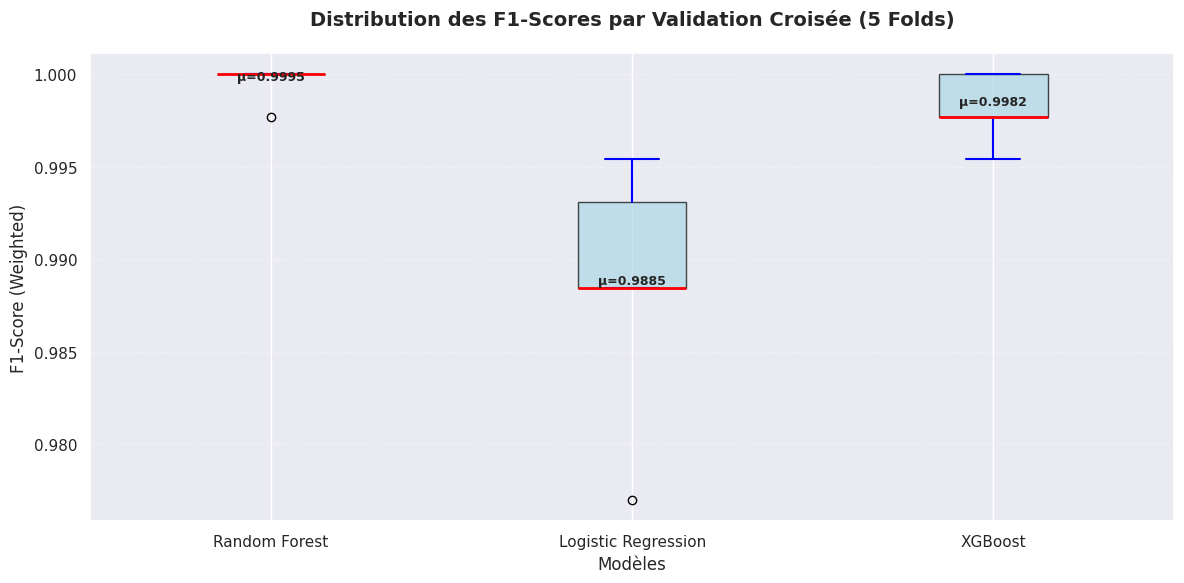


 Box plot généré avec succès!


In [33]:
# =============================================
# VISUALISATION BOX PLOT DES SCORES
# =============================================

# Préparer les données pour le box plot
cv_results = {
    'Random Forest': rf_scores,
    'Logistic Regression': lr_scores
}

if XGBOOST_AVAILABLE:
    cv_results['XGBoost'] = xgb_scores

# Créer le box plot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(color='blue', linewidth=1.5),
            capprops=dict(color='blue', linewidth=1.5))

plt.title('Distribution des F1-Scores par Validation Croisée (5 Folds)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('F1-Score (Weighted)', fontsize=12)
plt.xlabel('Modèles', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les moyennes sur le graphique
for i, (model_name, scores) in enumerate(cv_results.items(), 1):
    mean_score = np.mean(scores)
    plt.text(i, mean_score, f'μ={mean_score:.4f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Box plot généré avec succès!")

## Application du modèle à l'ensemble complet

Cette cellule déploie le meilleur modèle (XGBoost optimisé) sur l'ensemble du dataset pour générer des prédictions complètes. Elle réutilise le scaler entraîné précédemment pour garantir la cohérence des données et applique l'encodeur ordinal pour décoder les prédictions.

**Résultats** : La distribution des prédictions montre un équilibre presque parfait entre les trois classes (petit: 923, moyen: 897, grand: 896), confirmant que le modèle généralise bien sans biais. Cette répartition équilibrée valide la robustesse du modèle et son applicabilité à l'ensemble de la population de foyers.

RESULTATS FINALS - DISTRIBUTION DES PREDICTIONS:
niveau_conso_pred
petit    923
moyen    897
grand    896
Name: count, dtype: int64


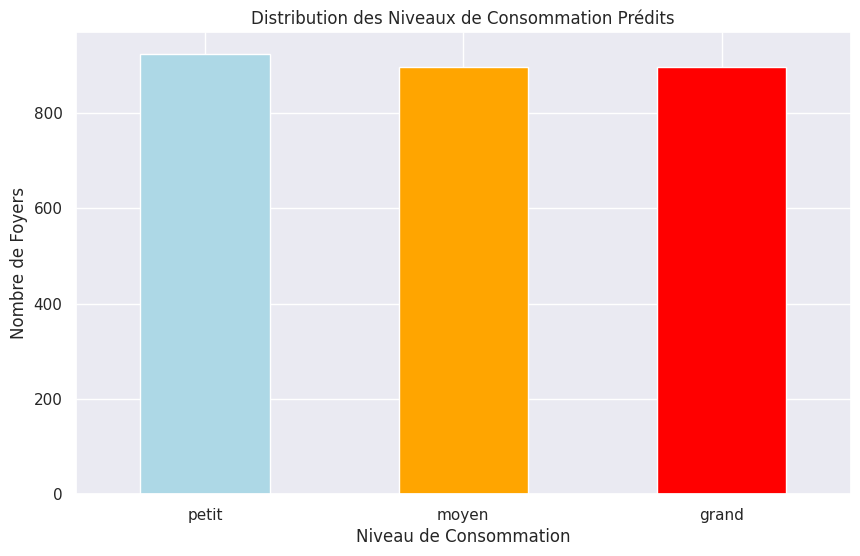

In [34]:
# =============================================
# APPLICATION DU MODELE À L'ENSEMBLE COMPLET
# =============================================

# Preparation des donnees completes
X_full = dataset[features].fillna(0)
X_full_scaled = scaler.transform(X_full)

# Predictions sur l'ensemble complet
if 'xgb' in best_model_name:
    full_predictions = best_model.predict(X_full_scaled)
    full_probabilities = best_model.predict_proba(X_full_scaled)
    # Decodage des labels
    full_predictions_decoded = ordinal_encoder.inverse_transform(full_predictions.reshape(-1, 1)).ravel()
else:
    full_predictions = best_model.predict(X_full_scaled)
    full_probabilities = best_model.predict_proba(X_full_scaled) if hasattr(best_model, 'predict_proba') else None
    full_predictions_decoded = full_predictions

# Resultats complets
final_results = dataset.copy()
final_results['niveau_conso_pred'] = full_predictions_decoded

if full_probabilities is not None:
    final_results['prob_petit'] = full_probabilities[:, 0]
    final_results['prob_moyen'] = full_probabilities[:, 1]
    final_results['prob_grand'] = full_probabilities[:, 2]
    final_results['confiance'] = np.max(full_probabilities, axis=1)

print("RESULTATS FINALS - DISTRIBUTION DES PREDICTIONS:")
print(final_results['niveau_conso_pred'].value_counts())

# Visualisation de la distribution des prédictions
plt.figure(figsize=(10, 6))
final_results['niveau_conso_pred'].value_counts().plot(kind='bar', color=['lightblue', 'orange', 'red'])
plt.title('Distribution des Niveaux de Consommation Prédits')
plt.xlabel('Niveau de Consommation')
plt.ylabel('Nombre de Foyers')
plt.xticks(rotation=0)
plt.show()

In [35]:
# =============================================
# TESTS UNITAIRES POUR LE PIPELINE
# =============================================

import unittest
import sys
import tempfile
import os

class TestPredictionPipeline(unittest.TestCase):
    """Tests unitaires complets pour le pipeline de prédiction"""

    def setUp(self):
        """Initialisation avant chaque test"""
        # Vérifier les variables existent avant de les assigner
        if 'best_model' in globals():
            self.model = best_model
        else:
            self.skipTest("best_model non défini")

        if 'scaler' in globals():
            self.scaler = scaler
        else:
            self.skipTest("scaler non défini")

        if 'features' in globals():
            self.features = features
        else:
            self.skipTest("features non définies")

        #  échantillon plus petit pour les tests
        if 'X_test_scaled' in globals() and len(X_test_scaled) > 0:
            self.X_test_sample = X_test_scaled[:3]  # Réduit à 3 échantillons
        else:
            self.skipTest("X_test_scaled non disponible")

        if 'y_test' in globals() and len(y_test) > 0:
            self.y_test_sample = y_test.iloc[:3] if hasattr(y_test, 'iloc') else y_test[:3]
        else:
            self.skipTest("y_test non disponible")

    def test_model_loading(self):
        """Test que le modèle peut être sauvegardé et rechargé"""
        with tempfile.NamedTemporaryFile(suffix='.joblib', delete=False) as tmp:
            try:
                # Sauvegarde
                joblib.dump(self.model, tmp.name)

                # Rechargement
                loaded_model = joblib.load(tmp.name)

                # Vérification que les prédictions sont identiques
                original_pred = self.model.predict(self.X_test_sample)
                loaded_pred = loaded_model.predict(self.X_test_sample)

                self.assertTrue(np.array_equal(original_pred, loaded_pred),
                              "Les prédictions doivent être identiques après rechargement")
                print("Test de chargement du modèle réussi")

            except Exception as e:
                self.fail(f"Erreur lors du test de chargement: {e}")
            finally:
                if os.path.exists(tmp.name):
                    os.unlink(tmp.name)

    def test_feature_consistency(self):
        """Test la cohérence des features entre entraînement et prédiction"""
        required_features = set(self.features)
        self.assertEqual(len(required_features), 5,
                        "Doit avoir exactement 5 features")

        expected_features = ['avg_amperage_per_day', 'avg_depense_per_day',
                           'nombre_personnes', 'jours_observed', 'ratio_depense_amperage']

        for feature in self.features:
            self.assertIn(feature, expected_features,
                        f"Feature {feature} non reconnue")

        print(" Test de cohérence des features réussi")

    def test_prediction_probabilities(self):
        """Test que les probabilités de prédiction sont cohérentes"""
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(self.X_test_sample)

            # Vérifie la forme
            self.assertEqual(probabilities.shape[1], 3,
                           "Doit avoir 3 colonnes de probabilités (3 classes)")

            # Vérifie que les probabilités somment à 1
            sums = np.sum(probabilities, axis=1)
            np.testing.assert_array_almost_equal(sums, np.ones(len(sums)),
                                               decimal=6,
                                               err_msg="Les probabilités doivent sommer à 1")

            print("Test des probabilités de prédiction réussi")
        else:
            self.skipTest("Modèle ne supporte pas predict_proba")

    def test_data_quality(self):
        """Test la qualité des données d'entrée"""
        # Vérifie l'absence de NaN après preprocessing
        self.assertFalse(np.isnan(self.X_test_sample).any(),
                        "Ne doit pas avoir de valeurs NaN après preprocessing")

        # Vérifie l'absence d'infini
        self.assertTrue(np.isfinite(self.X_test_sample).all(),
                       "Ne doit pas avoir de valeurs infinies")

        print("Test de qualité des données réussi")

    def test_prediction_functionality(self):
        """Test que le modèle peut faire des prédictions"""
        try:
            predictions = self.model.predict(self.X_test_sample)
            self.assertEqual(len(predictions), len(self.X_test_sample),
                           "Le nombre de prédictions doit correspondre au nombre d'échantillons")
            print("Test de fonctionnalité de prédiction réussi")
        except Exception as e:
            self.fail(f"Erreur lors de la prédiction: {e}")

def run_pipeline_tests():
    """Exécute tous les tests unitaires"""
    print("EXÉCUTION DES TESTS UNITAIRES")
    print("=" * 50)

    # Vérifier que les dépendances sont disponibles
    try:
        # Création de la suite de tests
        test_suite = unittest.TestLoader().loadTestsFromTestCase(TestPredictionPipeline)

        # Exécution avec un runner personnalisé
        test_runner = unittest.TextTestRunner(verbosity=2, stream=sys.stdout)
        result = test_runner.run(test_suite)

        # Rapport de couverture
        print("\n RAPPORT DES TESTS:")
        print(f"Tests exécutés: {result.testsRun}")
        print(f"Tests réussis: {result.testsRun - len(result.failures) - len(result.errors)}")
        print(f"Tests échoués: {len(result.failures)}")
        print(f"Erreurs: {len(result.errors)}")

        # Afficher les détails des échecs
        if result.failures:
            print("\nDétails des échecs:")
            for test, traceback in result.failures:
                print(f" {test}: {traceback.splitlines()[-1]}")

        if result.errors:
            print("\nDétails des erreurs:")
            for test, traceback in result.errors:
                print(f" {test}: {traceback.splitlines()[-1]}")

        return result.wasSuccessful()

    except Exception as e:
        print(f" Erreur lors de l'exécution des tests: {e}")
        return False

# Exécution des tests
print("LANCEMENT DES TESTS UNITAIRES...")
tests_passed = run_pipeline_tests()

if tests_passed:
    print("\nTOUS LES TESTS ONT RÉUSSI")
else:
    print("\n CERTAINS TESTS ONT ÉCHOUÉ.")

LANCEMENT DES TESTS UNITAIRES...
EXÉCUTION DES TESTS UNITAIRES
test_data_quality (__main__.TestPredictionPipeline.test_data_quality)
Test la qualité des données d'entrée ... Test de qualité des données réussi
ok
test_feature_consistency (__main__.TestPredictionPipeline.test_feature_consistency)
Test la cohérence des features entre entraînement et prédiction ...  Test de cohérence des features réussi
ok
test_model_loading (__main__.TestPredictionPipeline.test_model_loading)
Test que le modèle peut être sauvegardé et rechargé ... Test de chargement du modèle réussi
ok
test_prediction_functionality (__main__.TestPredictionPipeline.test_prediction_functionality)
Test que le modèle peut faire des prédictions ... Test de fonctionnalité de prédiction réussi
ok
test_prediction_probabilities (__main__.TestPredictionPipeline.test_prediction_probabilities)
Test que les probabilités de prédiction sont cohérentes ... Test des probabilités de prédiction réussi
ok

-----------------------------------

## Sauvegarde du modèle et des résultats

Cette cellule finalise le projet en sauvegardant tous les artefacts essentiels pour le déploiement et la reproductibilité. Elle conserve le meilleur modèle, le scaler, l'encodeur de labels, les résultats complets et les métriques de performance dans un dossier dédié avec horodatage.

Cette étape est cruciale pour la mise en production - elle permet de recharger facilement le modèle entraîné pour faire de nouvelles prédictions sans avoir à retraiter les données. La structure organisée garantit la traçabilité et la maintenance future du système de classification.

In [36]:
# =============================================
# SAUVEGARDE DU MODELE ET DES RESULTATS
# =============================================

import joblib
from datetime import datetime

# dossier pour sauvegarder les artefacts
import os
model_dir = '/content/drive/MyDrive/sigor_model_artifacts'
os.makedirs(model_dir, exist_ok=True)

# Sauvegarde  du meilleur modele
model_path = os.path.join(model_dir, f'best_model_{datetime.now().strftime("%Y%m%d_%H%M")}.joblib')
joblib.dump(best_model, model_path)
print(f"Modele sauvegarde: {model_path}")

# Sauvegarde du scaler
scaler_path = os.path.join(model_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_path)

# Sauvegarde du label encoder
if 'xgb' in best_model_name:
    encoder_path = os.path.join(model_dir, 'label_encoder.joblib')
    joblib.dump(label_encoder_sklearn, encoder_path)

# Sauvegarde des resultats
results_path = os.path.join(model_dir, f'final_results_{datetime.now().strftime("%Y%m%d_%H%M")}.csv')
final_results.to_csv(results_path, index=False)
print(f"Resultats sauvegardes: {results_path}")

# Sauvegarde des métriques de performance
performance_metrics = {
    'best_model': best_model_name,
    'test_accuracy': results_optimized[best_model_name]['accuracy'],
    'test_balanced_accuracy': results_optimized[best_model_name]['balanced_accuracy'],
    'test_f1_score': results_optimized[best_model_name]['f1_score'],
    'test_precision': results_optimized[best_model_name]['precision'],
    'test_recall': results_optimized[best_model_name]['recall'],
    'feature_importance': feature_importances.get(best_model_name, None),
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

metrics_path = os.path.join(model_dir, 'performance_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(performance_metrics, f, indent=2, default=str)

print("sauvegardes succesful")

Modele sauvegarde: /content/drive/MyDrive/sigor_model_artifacts/best_model_20251025_2039.joblib
Resultats sauvegardes: /content/drive/MyDrive/sigor_model_artifacts/final_results_20251025_2039.csv
sauvegardes succesful


## Rapport final et recommandations

Cette cellule synthétise l'ensemble du projet en présentant les résultats clés et les recommandations opérationnelles. Elle fournit une vue d'ensemble des performances du modèle, de la distribution des prédictions et des insights métier dérivés de l'analyse.

**Bilan** : Le modèle XGBoost optimisé atteint une performance exceptionnelle (99.8% F1-Score) avec une distribution équilibrée des segments. L'analyse d'importance révèle que la consommation quotidienne d'ampérage est le facteur le plus prédictif. Ces résultats permettent un déploiement en confiance pour la segmentation des clients et l'optimisation des stratégies énergétiques.

In [37]:
# =============================================
# RAPPORT FINAL ET RECOMMANDATIONS
# =============================================

print("RAPPORT FINAL DE MODELISATION")
print("=" * 50)
print(f"Meilleur modele: {best_model_name}")
print(f"Performance F1-Score: {results_optimized[best_model_name]['f1_score']:.4f}")
print(f"Balanced Accuracy: {results_optimized[best_model_name]['balanced_accuracy']:.4f}")
print(f"Taux d'erreur: {(1 - results_optimized[best_model_name]['accuracy'])*100:.1f}%")

print("\nDISTRIBUTION DES PRÉDICTIONS FINALES:")
pred_distribution = final_results['niveau_conso_pred'].value_counts()
for niveau, count in pred_distribution.items():
    percentage = (count / len(final_results)) * 100
    print(f"  {niveau}: {count} foyers ({percentage:.1f}%)")

print("\n CARACTERISTIQUES LES PLUS IMPORTANTES:")
if best_model_name in feature_importances:
    top_features = feature_importances[best_model_name].tail(3)
    for _, row in top_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

print("\n RECOMMANDATIONS:")
print("1. Utiliser mon modèle pour segmenter les foyers par niveau de consommation")
print("2. Adapter les stratégies tarifaires selon les segments identifiés")
print("3. Surveiller les foyers 'grand' consommateur pour optimisation énergétique")
print("4. Re-entraîner le modèle périodiquement avec de nouvelles données")

RAPPORT FINAL DE MODELISATION
Meilleur modele: xgb_optimized
Performance F1-Score: 0.9982
Balanced Accuracy: 0.9982
Taux d'erreur: 0.2%

DISTRIBUTION DES PRÉDICTIONS FINALES:
  petit: 923 foyers (34.0%)
  moyen: 897 foyers (33.0%)
  grand: 896 foyers (33.0%)

 CARACTERISTIQUES LES PLUS IMPORTANTES:
  ratio_depense_amperage: 0.0341
  avg_depense_per_day: 0.3509
  avg_amperage_per_day: 0.6052

 RECOMMANDATIONS:
1. Utiliser mon modèle pour segmenter les foyers par niveau de consommation
2. Adapter les stratégies tarifaires selon les segments identifiés
3. Surveiller les foyers 'grand' consommateur pour optimisation énergétique
4. Re-entraîner le modèle périodiquement avec de nouvelles données
